# Reproduceable Research: Artifact No. 2

In this notebook I continue exploratory analysis of the **Home Mortgage Disclosure Act** loan application data for 2024 and visualize `rate_spread`, `debt_to_income_ratio`, `loan_amount`, and `loan_to_value_ratio` broken down by `derived_race` and `derived_sex`.

Running this notebook requires initiating a High-Ram Python GPU otherwise it will timeout. Note that some code blocks (ex: kde2 clusters) may take 10-20 minutes to run.

The accompanying notebooks in this series are:
- [Artifcat No. 1: HMDA Gender and Geography](https://colab.research.google.com/drive/1bIIbRIASm6mOUk4jteGboGExWRyL6tDe?usp=sharing)
- [Artifcat No. 2: HMDA Loan Characteristics by Race & Gender](https://colab.research.google.com/drive/1w6yQhZUyiMK5FvECOKzvpNa8FClOQ0KU?usp=sharing)
- [Artifact No. 3: Tapping APIs for Multi-Year Analysis](https://colab.research.google.com/drive/1f2zZ_LIhGzuQVhrdgqVDT8nR3ff6DXze?usp=sharing)



## 1) Data Preparation

In 2024, there were over 12.2 applicant records reported under the HMDA. In this notebook I consider only single applicants who applied for a primary mortgage on a single family home (defined as dwellings with between 1-4 unites) and their reported data record is complete for the attributes I am interested in visualizing.



In [ ]:

# Install dependencies
!pip install pandas numpy seaborn matplotlib statsmodels

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


# Load dataset if CSV local
#file_path = 'contents/d.csv'  # Replace with your file path
#df = pd.read_csv(file_path)


from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # wait for auth flow



Mounted at /content/drive


In [ ]:
import os
print(os.listdir('/content/drive/MyDrive/CIS-2330_Database_Fundamentals')) # Replace with your google drive file path


['state-and-local-association-website-market-data-pages-urls-08-19-2022 (1).xls', '2024_combined_mlar.zip', 'tl_2024_us_state.zip', 'tl_2025_us_cbsa.zip', 'tl_2025_us_csa.zip', 'tl_2025_us_metdiv.zip', 'tl_2024_us_state', 'tl_2025_us_cbsa', 'applicantsDB', 'year_2024.csv', '2018-public-LAR-code-sheet.pdf']


In [ ]:
import os
from pathlib import Path

OUT_FIG_DIR = 'output/figures'
OUT_TAB_DIR = 'output/tables'
OUT_CKP_DIR = 'output/checkpoints'

Path(OUT_FIG_DIR).mkdir(parents=True, exist_ok=True)


for d in (OUT_FIG_DIR, OUT_TAB_DIR, OUT_CKP_DIR):
    Path(d).mkdir(parents=True, exist_ok=True)

def safe_save_csv(df, path, **kwargs):
    p = Path(path)
    p.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(p, **kwargs)
    print(f"Saved: {p}")

def safe_save_fig(path, dpi=300):
    p = Path(path)
    p.parent.mkdir(parents=True, exist_ok=True)
    import matplotlib.pyplot as plt
    plt.savefig(p, dpi=dpi)
    print(f"Saved: {p}")


In [ ]:
# Find the file that contrains 'year_2024' in name

import os

hmda_file_path = None
for root, dirs, files in os.walk('/content/drive/MyDrive/CIS-2330_Database_Fundamentals/'): #replace with your file path
    for file in files:
        if 'year_2024' in file.lower() and file.endswith('.csv'):
            hmda_file_path = os.path.join(root, file)
            print("Found HMDA file:", hmda_file_path)

if hmda_file_path is None:
    raise FileNotFoundError("HMDA file not found. Please check your Drive.")

Found HMDA file: /content/drive/MyDrive/CIS-2330_Database_Fundamentals/year_2024.csv


In [ ]:
# Validate the path copied from prior step is valid

# Write the path to variable
hdma2024 = '/content/drive/MyDrive/CIS-2330_Database_Fundamentals/year_2024.csv'

import os
assert os.path.exists(hdma2024), f"File not found: {hdma2024}"

print("Paths OK.")

Paths OK.


In [ ]:
# Create initial raw DataFrame

df = pd.read_csv(hdma2024, dtype=str, low_memory=False)

# This is necessary if using matplotlib or seaborn where '-' is an operator and its presence in the name of a variable will throw issues.
# Also generally good data practive to use underscores and lowercase for table naming conventions

df.columns = [col.replace('-', '_') for col in df.columns]

print("Dataset Shape:", df.shape)
print("Columns:", df.columns.tolist())

Dataset Shape: (12229298, 99)
Columns: ['activity_year', 'lei', 'derived_msa_md', 'state_code', 'county_code', 'census_tract', 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category', 'derived_ethnicity', 'derived_race', 'derived_sex', 'action_taken', 'purchaser_type', 'preapproval', 'loan_type', 'loan_purpose', 'lien_status', 'reverse_mortgage', 'open_end_line_of_credit', 'business_or_commercial_purpose', 'loan_amount', 'loan_to_value_ratio', 'interest_rate', 'rate_spread', 'hoepa_status', 'total_loan_costs', 'total_points_and_fees', 'origination_charges', 'discount_points', 'lender_credits', 'loan_term', 'prepayment_penalty_term', 'intro_rate_period', 'negative_amortization', 'interest_only_payment', 'balloon_payment', 'other_nonamortizing_features', 'property_value', 'construction_method', 'occupancy_type', 'manufactured_home_secured_property_type', 'manufactured_home_land_property_interest', 'total_units', 'multifamily_affordable_units', 'income', 'debt_to

In [ ]:

pd.unique(df.columns)


array(['activity_year', 'lei', 'derived_msa_md', 'state_code',
       'county_code', 'census_tract', 'conforming_loan_limit',
       'derived_loan_product_type', 'derived_dwelling_category',
       'derived_ethnicity', 'derived_race', 'derived_sex', 'action_taken',
       'purchaser_type', 'preapproval', 'loan_type', 'loan_purpose',
       'lien_status', 'reverse_mortgage', 'open_end_line_of_credit',
       'business_or_commercial_purpose', 'loan_amount',
       'loan_to_value_ratio', 'interest_rate', 'rate_spread',
       'hoepa_status', 'total_loan_costs', 'total_points_and_fees',
       'origination_charges', 'discount_points', 'lender_credits',
       'loan_term', 'prepayment_penalty_term', 'intro_rate_period',
       'negative_amortization', 'interest_only_payment',
       'balloon_payment', 'other_nonamortizing_features',
       'property_value', 'construction_method', 'occupancy_type',
       'manufactured_home_secured_property_type',
       'manufactured_home_land_property_inte

In [ ]:
df.describe()

,activity_year,lei,derived_msa_md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason_2,denial_reason_3,denial_reason_4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
count,12229298,12229298,12229298,12013496,11931113,11878672,12185841,12229298,12229298,12229298,...,469830,87481,15829,12229298,12229298,12229298,12229298,12229298,12229298,12229298
unique,1,4908,418,54,3223,83891,3,8,4,5,...,9,9,9,8280,9749,326,348,2835,3516,77
top,2024,549300FGXN1K3HLB1R50,99999,TX,06037,48201543005,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,3,9,9,0,0,100900,0,0,0,0
freq,12229298,553854,1780667,1069032,199303,4639,11838741,6424537,11499654,7523406,...,109693,25020,11825,350850,351063,317515,408570,353853,354213,851413


In [ ]:

df.info()
rawdatahead = df.head()

# Write sample to CSV for easy review
safe_save_csv(rawdatahead, f'{OUT_TAB_DIR}/rawdatahead.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12229298 entries, 0 to 12229297
Data columns (total 99 columns):
 #   Column                                    Dtype 
---  ------                                    ----- 
 0   activity_year                             object
 1   lei                                       object
 2   derived_msa_md                            object
 3   state_code                                object
 4   county_code                               object
 5   census_tract                              object
 6   conforming_loan_limit                     object
 7   derived_loan_product_type                 object
 8   derived_dwelling_category                 object
 9   derived_ethnicity                         object
 10  derived_race                              object
 11  derived_sex                               object
 12  action_taken                              object
 13  purchaser_type                            object
 14  preapproval     

In [ ]:
# Columns to load for efficiency
use_cols = [
    'derived_sex', 'derived_ethnicity', 'derived_race',
    'loan_to_value_ratio', 'debt_to_income_ratio', 'rate_spread',
    'interest_rate', 'loan_amount', 'occupancy_type', 'loan_type',
    'loan_purpose', 'action_taken'
]

# Load in chunks to avoid memory overload
chunks = []
chunk_size = 1_000_000  # Adjust if needed
for chunk in pd.read_csv(hdma2024, usecols=use_cols, chunksize=chunk_size, low_memory=False):
    chunks.append(chunk)

derived_df = pd.concat(chunks, ignore_index=True)

# Rename columns: replace '-' with '_'
derived_df.columns = [col.replace('-', '_') for col in derived_df.columns]

print("Data Loaded:", derived_df.shape)
print("Columns:", derived_df.columns.tolist())


Data Loaded: (12229298, 12)
Columns: ['derived_ethnicity', 'derived_race', 'derived_sex', 'action_taken', 'loan_type', 'loan_purpose', 'loan_amount', 'loan_to_value_ratio', 'interest_rate', 'rate_spread', 'occupancy_type', 'debt_to_income_ratio']


In [ ]:
df_noNA = derived_df.dropna(subset=['derived_sex', 'derived_ethnicity', 'derived_race', 'action_taken']).copy()

# Normalize categorical values
categorical_cols = ['derived_sex', 'derived_ethnicity', 'derived_race',
                    'occupancy_type', 'loan_type', 'loan_purpose']
for col in categorical_cols:
    df_noNA[col] = df_noNA[col].astype(str).str.lower()

# Define categories to exclude after lowercasing
exclude_derived_sex = ['sex not available', 'joint']
exclude_derived_ethnicity = ['ethnicity not available', 'joint', 'free form text only']
exclude_derived_race = ['race not available', 'joint', '2 or more minority races', 'free form text only']

# Apply exclusions
df_noNA = df_noNA[~df_noNA['derived_sex'].isin(exclude_derived_sex)]
df_noNA = df_noNA[~df_noNA['derived_ethnicity'].isin(exclude_derived_ethnicity)]
df_noNA = df_noNA[~df_noNA['derived_race'].isin(exclude_derived_race)]

# Convert numeric columns on a copy of df_noNA for sampledf
sampledf = df_noNA.copy()
numeric_cols = ['loan_to_value_ratio', 'debt_to_income_ratio', 'rate_spread',
                'interest_rate', 'loan_amount']
for col in numeric_cols:
    sampledf[col] = pd.to_numeric(sampledf[col], errors='coerce')

# Drop rows with missing numeric values
sampledf = sampledf.dropna(subset=numeric_cols)

print("Cleaned Data Shape:", sampledf.shape)

Cleaned Data Shape: (1478781, 12)


In [ ]:

print("===== Describe Data =====")
print(sampledf.describe(include='all'))



===== Describe Data =====
             derived_ethnicity derived_race derived_sex  action_taken  \
count                  1478781      1478781     1478781  1.478781e+06   
unique                       2            5           2           NaN   
top     not hispanic or latino        white        male           NaN   
freq                   1257611      1149372      859134           NaN   
mean                       NaN          NaN         NaN  1.126140e+00   
std                        NaN          NaN         NaN  7.799067e-01   
min                        NaN          NaN         NaN  1.000000e+00   
25%                        NaN          NaN         NaN  1.000000e+00   
50%                        NaN          NaN         NaN  1.000000e+00   
75%                        NaN          NaN         NaN  1.000000e+00   
max                        NaN          NaN         NaN  8.000000e+00   

       loan_type loan_purpose   loan_amount  loan_to_value_ratio  \
count    1478781      1478781

In [ ]:
print(sampledf.derived_sex.value_counts())
print(sampledf.derived_ethnicity.value_counts())
print(sampledf.derived_race.value_counts())

# COME BACK to create a Race/Ethnicity variable using only race masks experience of Hispanic and Latino



# Only considering single applicants
# clear limitation --> think about how to approach
#

derived_sex
male      859134
female    619647
Name: count, dtype: int64
derived_ethnicity
not hispanic or latino    1257611
hispanic or latino         221170
Name: count, dtype: int64
derived_race
white                                        1149372
black or african american                     177458
asian                                         132883
american indian or alaska native               14720
native hawaiian or other pacific islander       4348
Name: count, dtype: int64


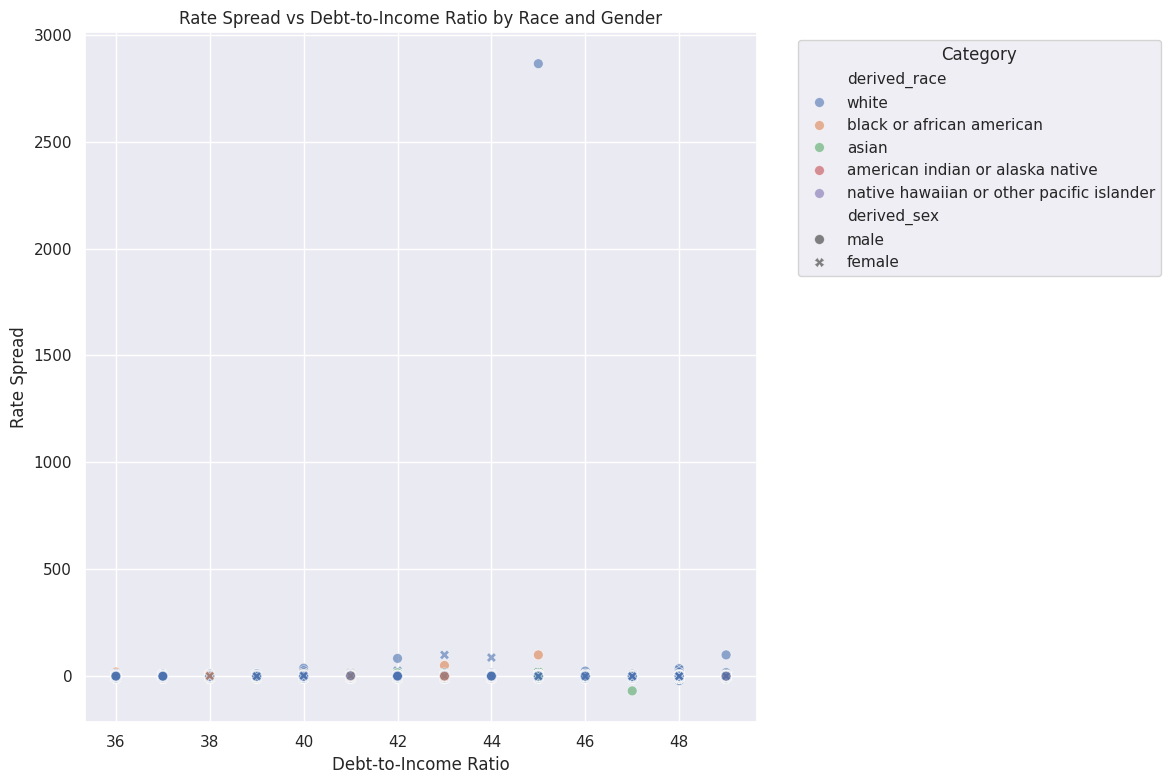

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Set a style
sns.set(style="darkgrid")

# Create the scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=sampledf,
    x='debt_to_income_ratio',
    y='rate_spread',
    hue='derived_race',  # Color by race
    style='derived_sex',          # Shape by gender
    alpha=0.6,
    s=50                     # Size of markers
)

plt.title('Rate Spread vs Debt-to-Income Ratio by Race and Gender')
plt.xlabel('Debt-to-Income Ratio')
plt.ylabel('Rate Spread')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside the plot
plt.grid(True)
plt.tight_layout()
plt.show()


# Later examine this outlier when have time

In [ ]:
# Look at data again more closely at 1% & 99% CI -->
# The default confidence internals sampledf.describe() is 25% 50% 75% need more precision
# Define percentiles as desired

from numpy.random import sample
# Inspect unique race categories and their counts
print("Unique derived_race categories and their counts:")
print(sampledf['derived_race'].value_counts())
print(f"Number of unique race categories: {sampledf['derived_race'].nunique()}")

# Inspect descriptive statistics for the numeric variables
print("\nDescriptive statistics for debt_to_income_ratio:")
print(sampledf['debt_to_income_ratio'].describe(percentiles=[.01, .05, .25, .50, .75, .95, .99]))

print("\nDescriptive statistics for rate_spread:")
print(sampledf['rate_spread'].describe(percentiles=[.01, .05, .25, .50, .75, .95, .99]))

print("\nDescriptive statistics for loan_amount")
print(sampledf['loan_amount'].describe(percentiles=[.01, .05, .25, .50, .75, .95, .99]))

print("\nDescriptive statistics for loan_to_value_ratio")
print(sampledf['loan_to_value_ratio'].describe(percentiles=[.01, .05, .25, .50, .75, .95, .99]))

safe_save_csv(sampledf.derived_race.value_counts(), f'{OUT_TAB_DIR}/derived_race_counts.csv')
safe_save_csv(sampledf.debt_to_income_ratio.describe(percentiles=[.01, .05, .25, .50, .75, .99]), f'{OUT_TAB_DIR}/debt_to_income_ratio_stats.csv')

Unique derived_race categories and their counts:
derived_race
white                                        1149372
black or african american                     177458
asian                                         132883
american indian or alaska native               14720
native hawaiian or other pacific islander       4348
Name: count, dtype: int64
Number of unique race categories: 5

Descriptive statistics for debt_to_income_ratio:
count    1.478781e+06
mean     4.297958e+01
std      3.996721e+00
min      3.600000e+01
1%       3.600000e+01
5%       3.600000e+01
25%      4.000000e+01
50%      4.300000e+01
75%      4.600000e+01
95%      4.900000e+01
99%      4.900000e+01
max      4.900000e+01
Name: debt_to_income_ratio, dtype: float64

Descriptive statistics for rate_spread:
count    1.478781e+06
mean     6.373131e-01
std      2.908719e+00
min     -6.822000e+01
1%      -6.249000e+00
5%      -1.160000e+00
25%     -8.500000e-02
50%      4.000000e-01
75%      1.100000e+00
95%      3.7850

## 2) Data Clean-Up

Creating a new DataFrame `df_filtered` by filtering out extreme outliers from `sampledf` using the 1st and 99th percentiles for `debt_to_income_ratio`, `loan_to_value_ratio`, `loan_amount` and `rate_spread`.

In [ ]:
dti_lower_bound = sampledf['debt_to_income_ratio'].quantile(0.01)
dti_upper_bound = sampledf['debt_to_income_ratio'].quantile(0.99)
rate_spread_lower_bound = sampledf['rate_spread'].quantile(0.01)
rate_spread_upper_bound = sampledf['rate_spread'].quantile(0.99)
loan_amount_lower_bound = sampledf['loan_amount'].quantile(0.01)
loan_amount_upper_bound = sampledf['loan_amount'].quantile(0.99)
loan_to_value_lower_bound = sampledf['loan_to_value_ratio'].quantile(0.01)
loan_to_value_upper_bound = sampledf['loan_to_value_ratio'].quantile(0.99)

df_filtered = sampledf[
    (sampledf['debt_to_income_ratio'] >= dti_lower_bound) &
    (sampledf['debt_to_income_ratio'] <= dti_upper_bound) &
    (sampledf['rate_spread'] >= rate_spread_lower_bound) &
    (sampledf['rate_spread'] <= rate_spread_upper_bound) &
    (sampledf['loan_amount'] >= loan_amount_lower_bound) &
    (sampledf['loan_amount'] <= loan_amount_upper_bound) &
    (sampledf['loan_to_value_ratio'] >= loan_to_value_lower_bound) &
    (sampledf['loan_to_value_ratio'] <= loan_to_value_upper_bound)
].copy()

# Ensure 'derived_sex' column is correctly defined (using derived_sex as it exists in sampledf)
df_filtered['derived_sex'] = df_filtered['derived_sex'].astype('category')

# Ensure 'derived_race' is included and set as a categorical type
df_filtered['derived_race'] = df_filtered['derived_race'].astype('category')

print(f"Shape of df_filtered after outlier removal: {df_filtered.shape}")
print("\nDescriptive statistics for debt_to_income_ratio in df_filtered:")
print(df_filtered['debt_to_income_ratio'].describe(percentiles=[.01, .05, .25, .50, .75, .95, .99]))

print("\nDescriptive statistics for rate_spread in df_filtered:")
print(df_filtered['rate_spread'].describe(percentiles=[.01, .05, .25, .50, .75, .95, .99]))

print("\nDescriptive statistics for loan_amount in df_filtered:")
print(df_filtered['loan_amount'].describe(percentiles=[.01, .05, .25, .50, .75, .95, .99]))

print("\nDescriptive statistics for loan_to_value_ratio in df_filtered:")
print(df_filtered['loan_to_value_ratio'].describe(percentiles=[.01, .05, .25, .50, .75, .95, .99]))

Shape of df_filtered after outlier removal: (1402538, 12)

Descriptive statistics for debt_to_income_ratio in df_filtered:
count    1.402538e+06
mean     4.300102e+01
std      3.999764e+00
min      3.600000e+01
1%       3.600000e+01
5%       3.600000e+01
25%      4.000000e+01
50%      4.300000e+01
75%      4.600000e+01
95%      4.900000e+01
99%      4.900000e+01
max      4.900000e+01
Name: debt_to_income_ratio, dtype: float64

Descriptive statistics for rate_spread in df_filtered:
count    1.402538e+06
mean     6.568495e-01
std      1.372615e+00
min     -6.249000e+00
1%      -2.220000e+00
5%      -9.790000e-01
25%     -6.900000e-02
50%      4.020000e-01
75%      1.081000e+00
95%      3.515000e+00
99%      5.204000e+00
max      6.195000e+00
Name: rate_spread, dtype: float64

Descriptive statistics for loan_amount in df_filtered:
count    1.402538e+06
mean     2.634491e+05
std      1.912934e+05
min      1.500000e+04
1%       2.500000e+04
5%       4.500000e+04
25%      1.150000e+05
50%   

Now that I have excluded outliers re-plotting using the `df_filtered` DataFrame to visualize the relationship between `rate_spread` and `debt_to_income_ratio`, colored by `derived_race` and styled by `derived_sex`.



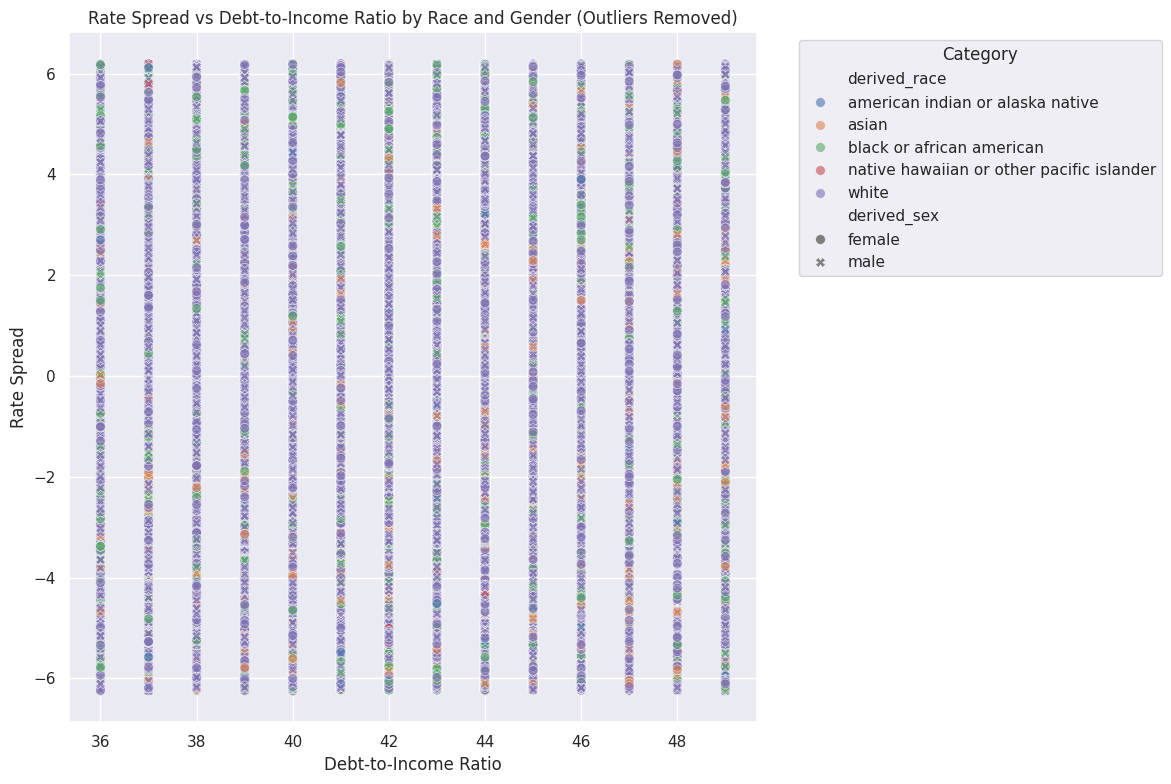

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style
sns.set(style="darkgrid")

# Create the scatter plot using df_filtered
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_filtered,
    x='debt_to_income_ratio',
    y='rate_spread',
    hue='derived_race',  # Color by race
    style='derived_sex',          # Shape by gender
    alpha=0.6,
    s=50                     # Size of markers
)

plt.title('Rate Spread vs Debt-to-Income Ratio by Race and Gender (Outliers Removed)')
plt.xlabel('Debt-to-Income Ratio')
plt.ylabel('Rate Spread')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside the plot
plt.grid(True)
plt.tight_layout()
plt.show()

Opps, that really didn't tell me much given that `debt_to_income_ratio` is discrete so I will attempt a different approach using a density plot.

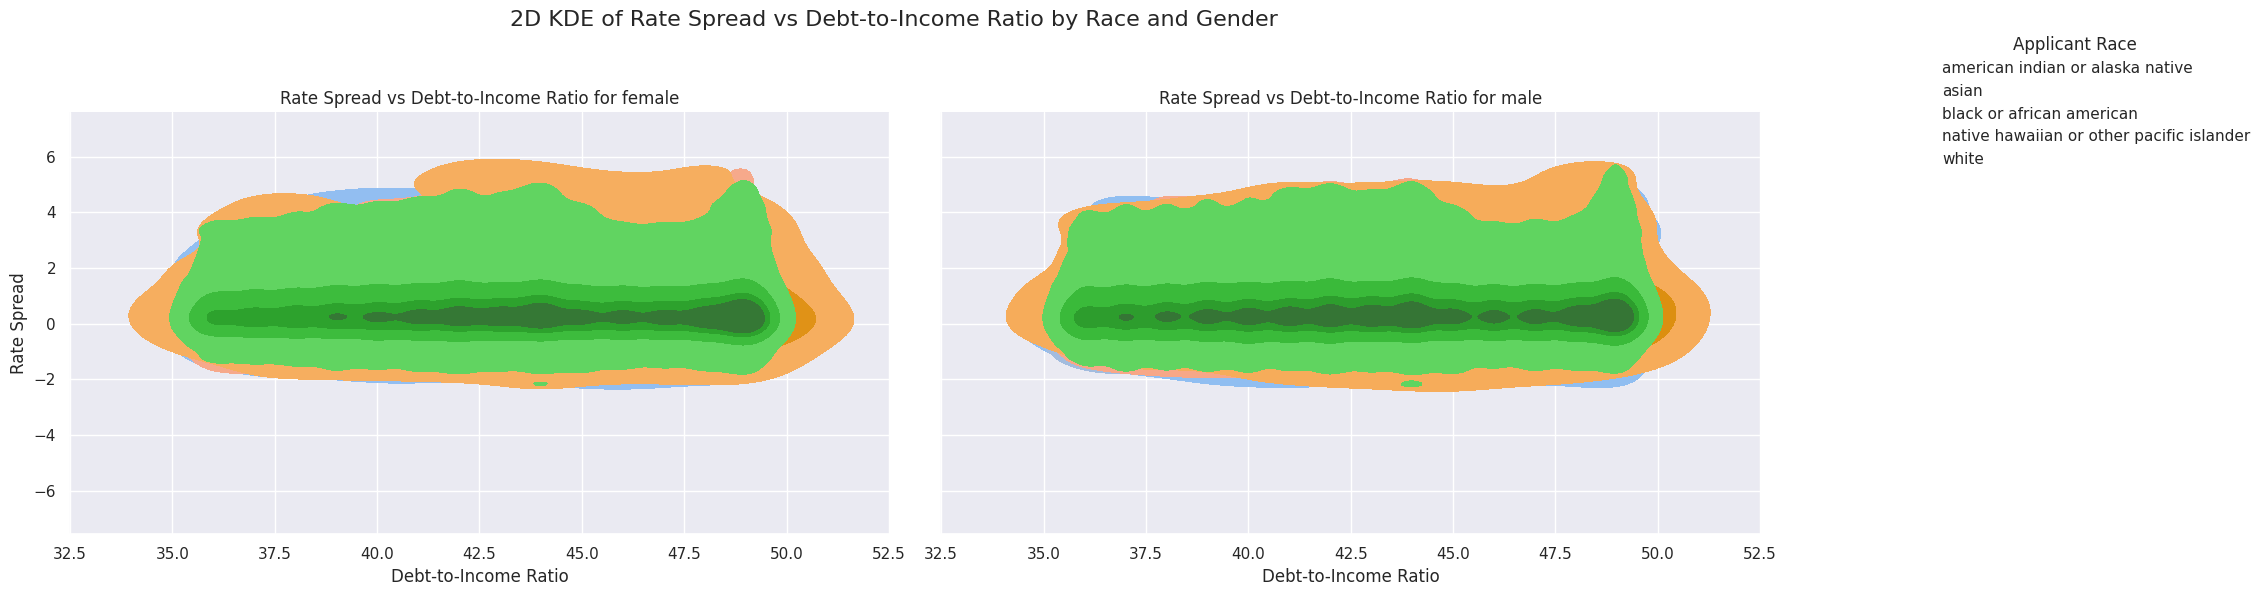

Saved: output/figures/kde_rate_spread_dti_race_gender.png


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns # https://seaborn.pydata.org/tutorial/distributions.html

# This was my first attempt at using Seaborn which is built on matplotlib and pandas.
# I am still working to update legends and formats.
# Check back for updates to the GitHub repo where they will be published.

sns.set(style="darkgrid")

g = sns.FacetGrid(df_filtered, col="derived_sex", hue="derived_race", height=6, aspect=1.2, col_wrap=2, palette="tab20")
g.map(sns.kdeplot, "debt_to_income_ratio", "rate_spread", fill=True, levels=5)
g.add_legend(title='Applicant Race', bbox_to_anchor=(1.05, 1), loc='upper left') #the legend color is not rendering on the legend adjecent labels FIX THIS

for ax in g.axes.flat:
    ax.set_title(f'Rate Spread vs Debt-to-Income Ratio for {ax.get_title().split("=")[1].strip()}')
    ax.set_xlabel('Debt-to-Income Ratio')
    ax.set_ylabel('Rate Spread')

plt.suptitle('2D KDE of Rate Spread vs Debt-to-Income Ratio by Race and Gender', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

#These are not printing correctly and show up as white space. Need to manually save from console. Need to be fixed
safe_save_fig(f'{OUT_FIG_DIR}/kde_rate_spread_dti_race_gender.png')

Even though I have not figured out the legends just yet this is getting abit closer to what I want to visualized. I can see there is a clear difference between groups though not in a way that provides me insights just yet. Also on save these are not rendering. Will need to come back to address later

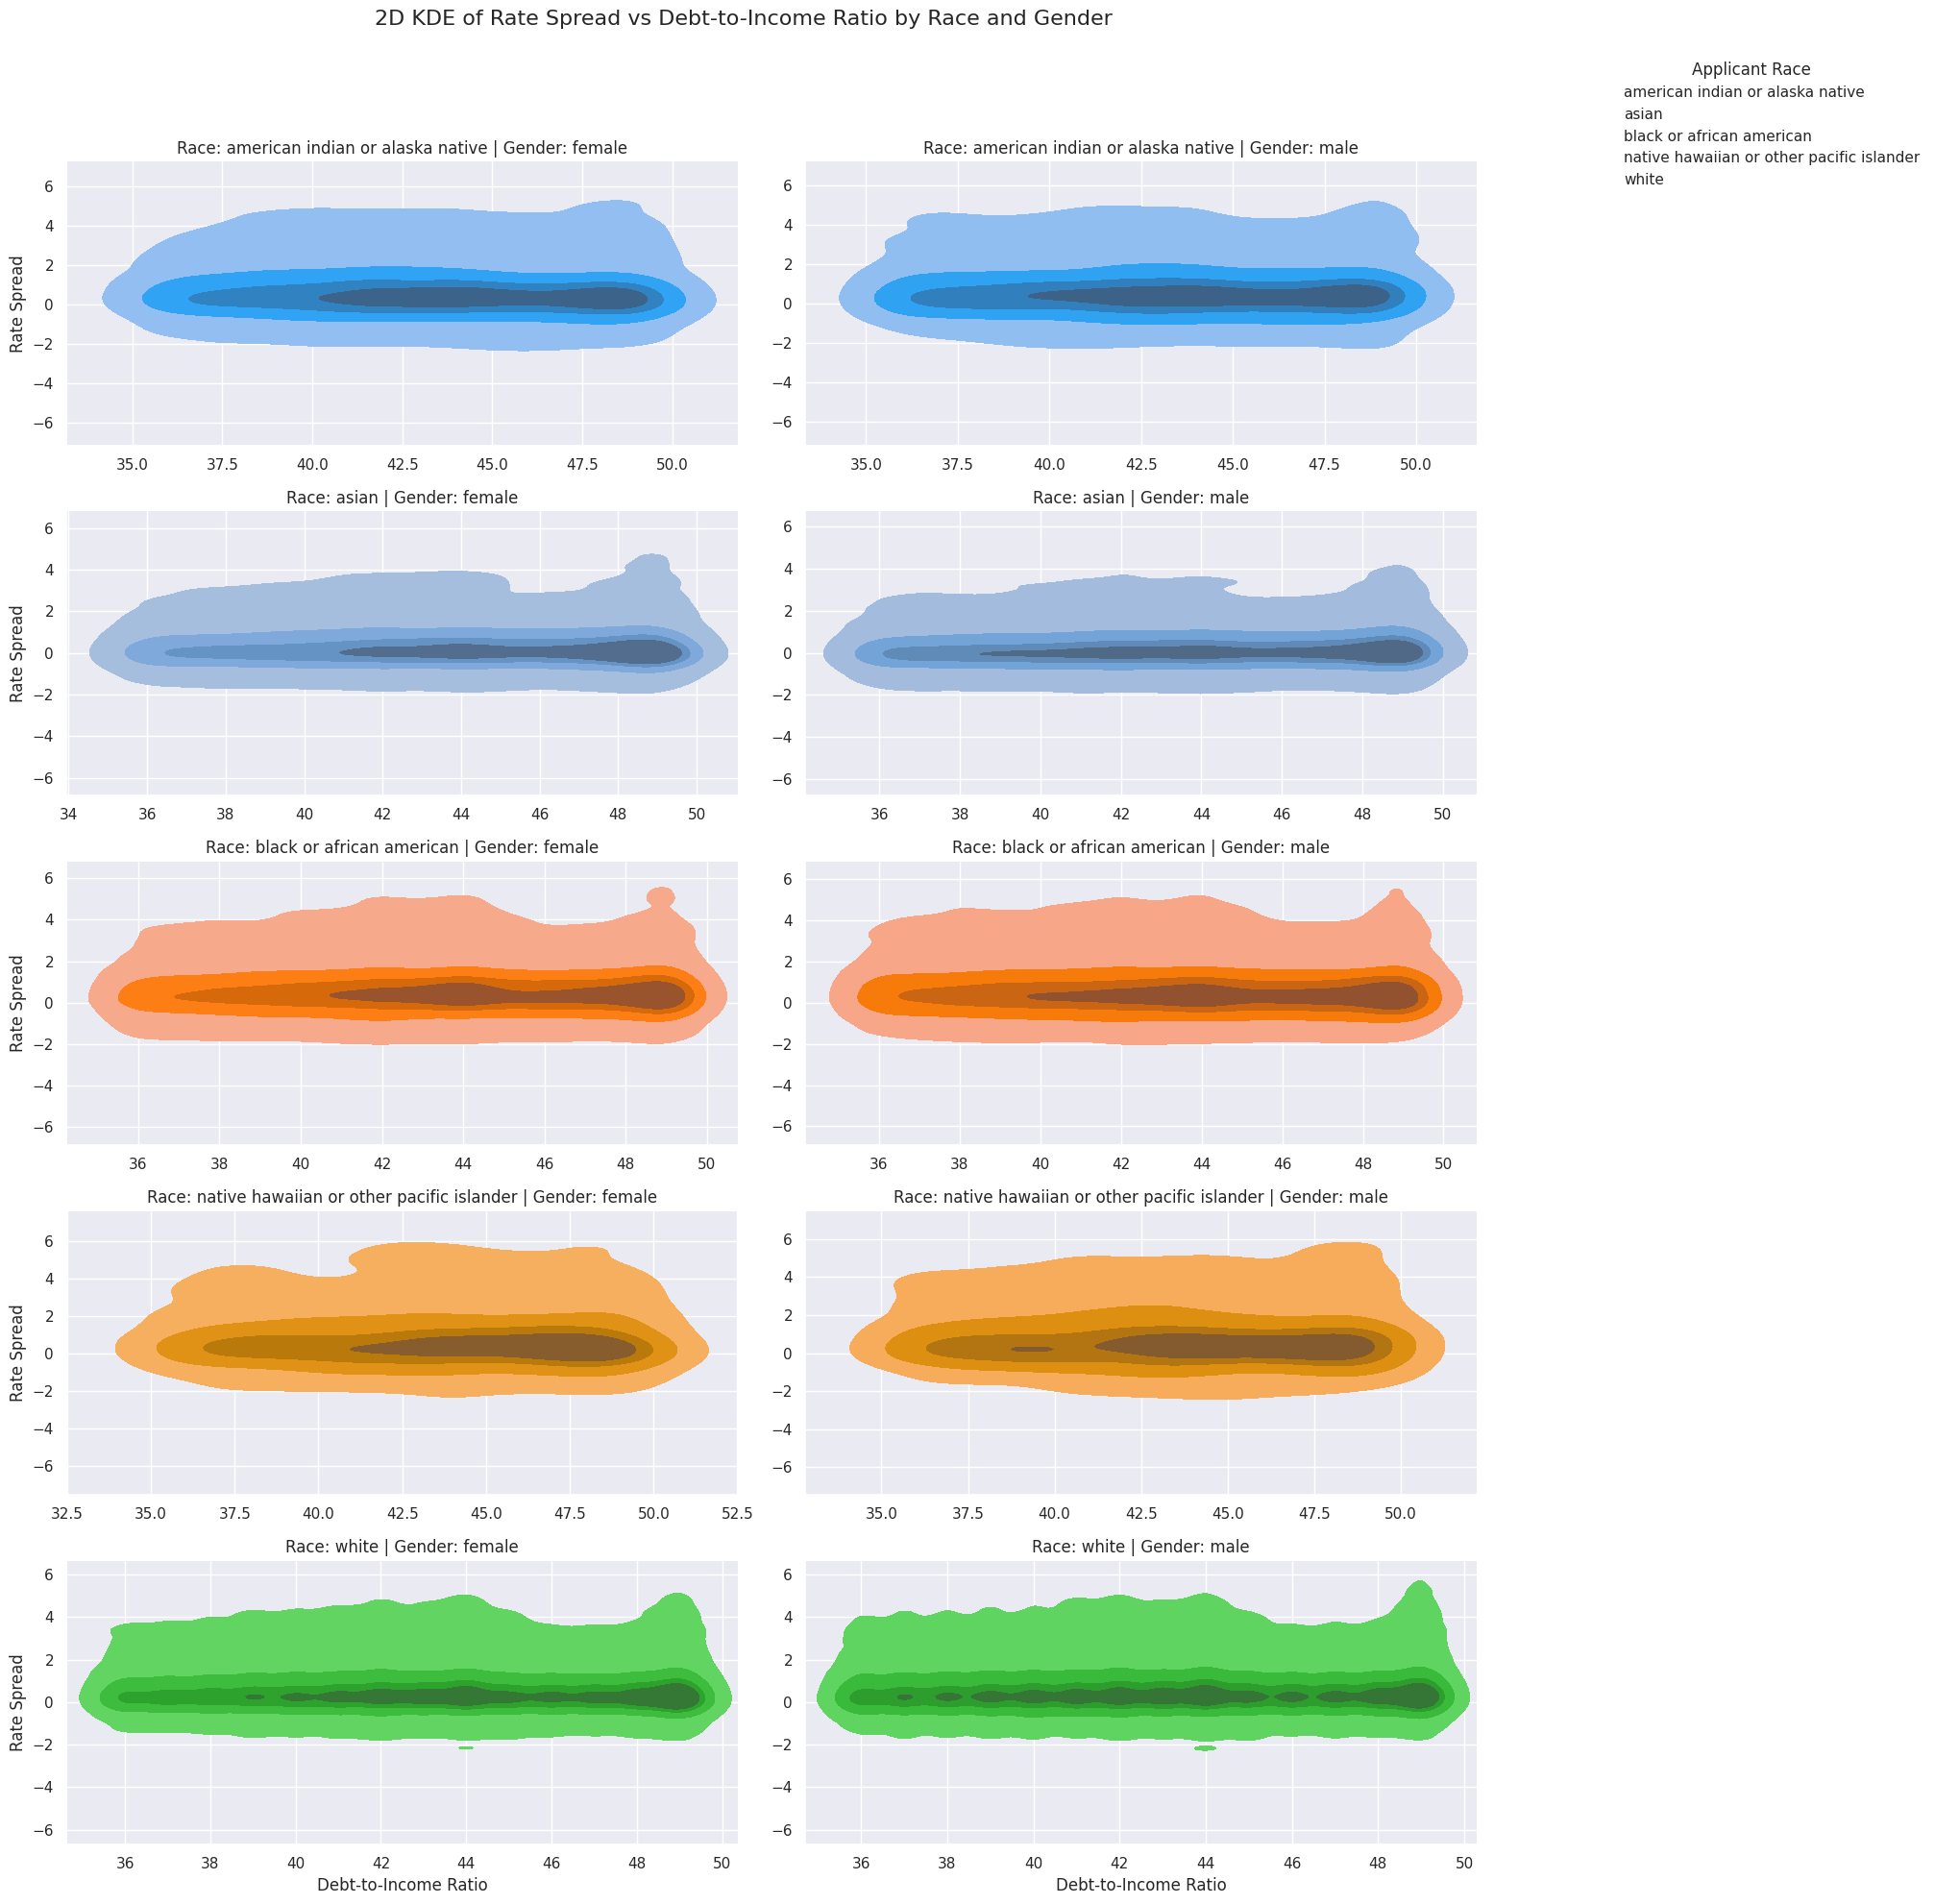

Saved: output/figures/kde_rate_spread_dti_race_gender_grid.png


<Figure size 640x480 with 0 Axes>

In [ ]:
# Replot using FacetGrid.set_titles calling race variable as 'row'
# Legend is still an issue why?

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

g = sns.FacetGrid(df_filtered, row="derived_race", col="derived_sex", height=4, aspect=1.5, hue="derived_race", palette="tab20", sharex=False, sharey=False)
g.map(sns.kdeplot, "debt_to_income_ratio", "rate_spread", fill=True, levels=5)
g.add_legend(title='Applicant Race', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set titles for each facet correctly using row_name and col_name
# https://seaborn.pydata.org/generated/seaborn.FacetGrid.set_titles.html
g.set_titles(row_template='Race: {row_name}', col_template='Gender: {col_name}')

# Set common x and y labels if needed, otherwise FacetGrid handles it
g.set_xlabels('Debt-to-Income Ratio')
g.set_ylabels('Rate Spread')

plt.suptitle('2D KDE of Rate Spread vs Debt-to-Income Ratio by Race and Gender', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

#These are not printing correctly and show up as white space. Need to manually save from console. Need to be fixed
safe_save_fig(f'{OUT_FIG_DIR}/kde_rate_spread_dti_race_gender_grid.png')

In [ ]:
safe_save_fig(f'{OUT_FIG_DIR}/kde_rate_spread_dti_race_gender_grid.png')

Saved: output/figures/kde_rate_spread_dti_race_gender_grid.png


<Figure size 640x480 with 0 Axes>

In [ ]:
from numpy.random import sample
# Inspect unique race categories and their counts
print("Unique derived_race categories and their counts:")
print(df_filtered['derived_race'].value_counts())
print(f"Number of unique race categories: {sampledf['derived_race'].nunique()}")

print("Unique derived_gender categories and their counts:")
print(df_filtered['derived_sex'].value_counts())
print(f"Number of unique gender categories: {sampledf['derived_race'].nunique()}")

Unique derived_race categories and their counts:
derived_race
white                                        1091703
black or african american                     166478
asian                                         126354
american indian or alaska native               13865
native hawaiian or other pacific islander       4138
Name: count, dtype: int64
Number of unique race categories: 5
Unique derived_gender categories and their counts:
derived_sex
male      816241
female    586297
Name: count, dtype: int64
Number of unique gender categories: 5


## 3) Loan Approval Rates by Rate and Sex in 2024

Calculate approval rates for each group and then provide side-by-side comparison.


### 3.a. Loan Approval Rates by Race for Women

In [ ]:
df_women = df_filtered[df_filtered['derived_sex'] == 'female'].copy()
df_women['approved'] = (df_women['action_taken'] == 1).astype(int)

print("df_women shape:", df_women.shape)
print("Approved column created and converted to integer type.")

df_women shape: (586297, 13)
Approved column created and converted to integer type.


In [ ]:
approval_rates_women_by_race = df_women.groupby('derived_race', observed=False)['approved'].mean().reset_index()
approval_rates_women_by_race.rename(columns={'approved': 'approval_rate'}, inplace=True)

print("Loan Approval Rates for Women by Race:")
print(approval_rates_women_by_race)

safe_save_csv(approval_rates_women_by_race, f'{OUT_TAB_DIR}/approvalrates_women_x_race.csv')

Loan Approval Rates for Women by Race:
                                derived_race  approval_rate
0           american indian or alaska native       0.941432
1                                      asian       0.948570
2                  black or african american       0.941427
3  native hawaiian or other pacific islander       0.924034
4                                      white       0.950704
Saved: output/tables/approvalrates_women_x_race.csv


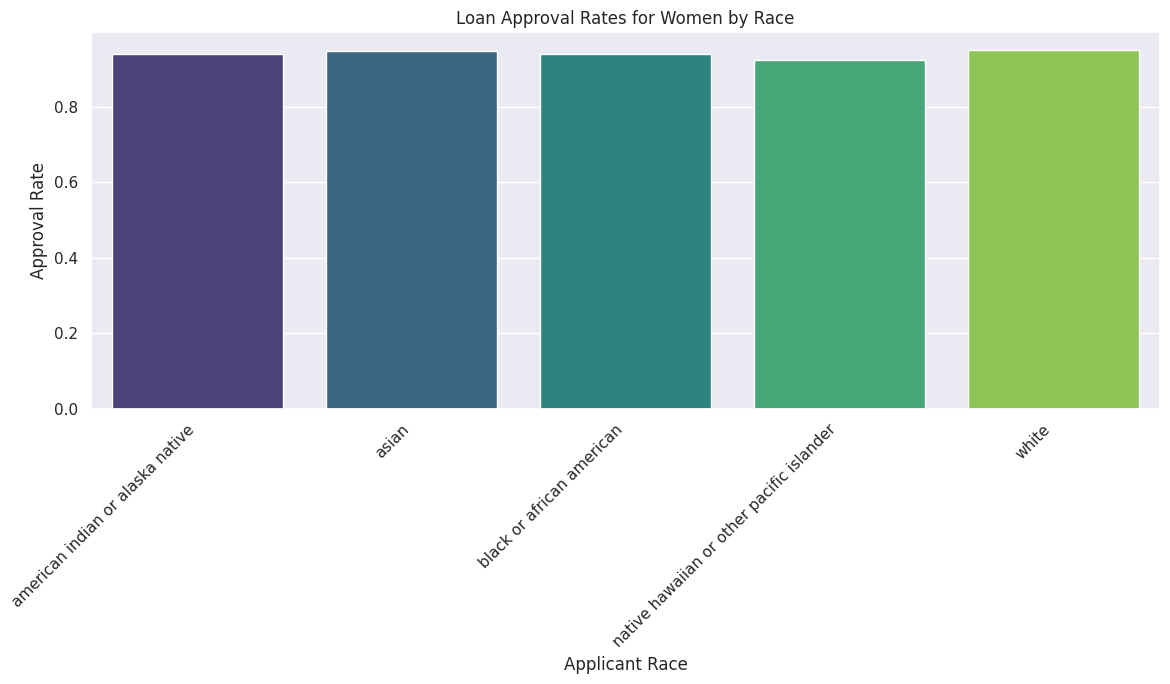

Saved: output/figures/loan_approval_rates_women_by_race.png


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.barplot(x='derived_race', y='approval_rate', hue='derived_race', data=approval_rates_women_by_race, palette='viridis', legend=False)
plt.title('Loan Approval Rates for Women by Race')
plt.xlabel('Applicant Race')
plt.ylabel('Approval Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

safe_save_fig(f'{OUT_FIG_DIR}/loan_approval_rates_women_by_race.png')

### 3.b. Loan Approval Rates for Males by Race




In [ ]:
df_men = df_filtered[df_filtered['derived_sex'] == 'male'].copy()
df_men['approved'] = (df_men['action_taken'] == 1).astype(int)

print("df_men shape:", df_men.shape)
print("Approved column created and converted to integer type.")

df_men shape: (816241, 13)
Approved column created and converted to integer type.


In [ ]:
approval_rates_men_by_race = df_men.groupby('derived_race', observed=False)['approved'].mean().reset_index()
approval_rates_men_by_race.rename(columns={'approved': 'approval_rate'}, inplace=True)

print("Loan Approval Rates for Men by Race:")
print(approval_rates_men_by_race)

safe_save_csv(approval_rates_men_by_race, f'{OUT_TAB_DIR}/approvalrates_men_x_race.csv')

Loan Approval Rates for Men by Race:
                                derived_race  approval_rate
0           american indian or alaska native       0.941557
1                                      asian       0.942448
2                  black or african american       0.938484
3  native hawaiian or other pacific islander       0.938721
4                                      white       0.948091
Saved: output/tables/approvalrates_men_x_race.csv


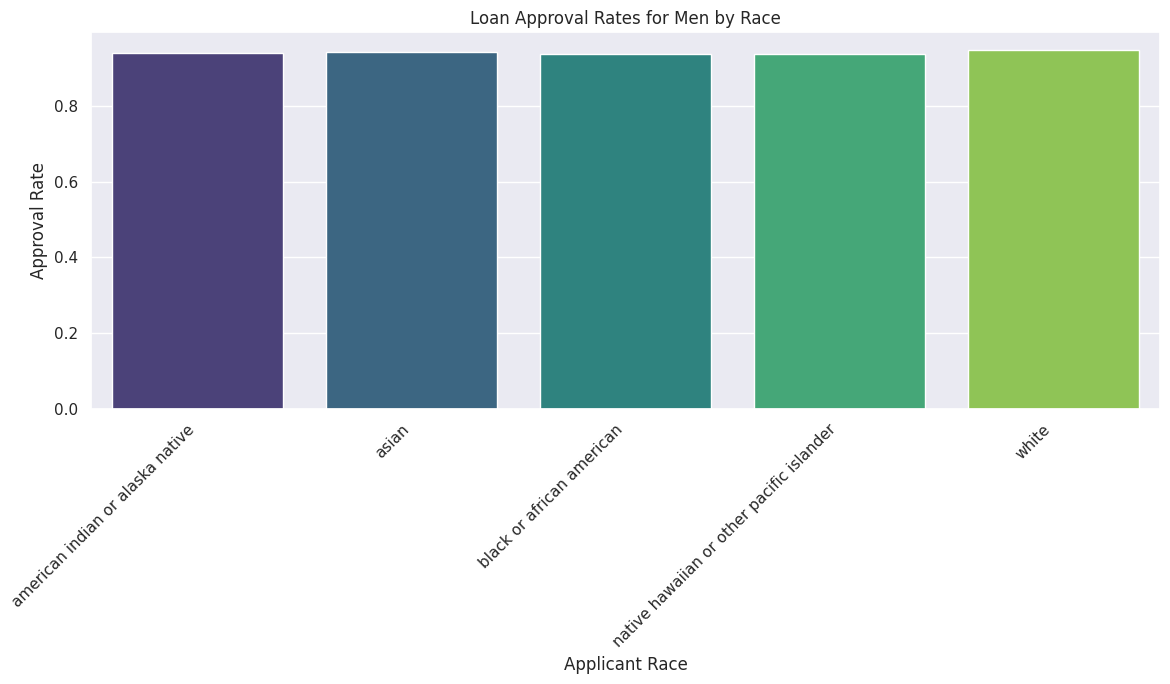

Saved: output/figures/loan_approval_rates_men_by_race.png


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.barplot(x='derived_race', y='approval_rate', hue='derived_race', data=approval_rates_men_by_race, palette='viridis', legend=False)
plt.title('Loan Approval Rates for Men by Race')
plt.xlabel('Applicant Race')
plt.ylabel('Approval Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

safe_save_fig(f'{OUT_FIG_DIR}/loan_approval_rates_men_by_race.png')

### 3.c. Loan Approval Rates Gender & Race Comparison

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add a 'gender' column to each DataFrame for differentiation
approval_rates_women_by_race['gender'] = 'Female'
approval_rates_men_by_race['gender'] = 'Male'

# Concatenate the two DataFrames
combined_approval_rates = pd.concat([approval_rates_women_by_race, approval_rates_men_by_race], ignore_index=True)

print("Combined Loan Approval Rates by Race and Gender:")
print(combined_approval_rates)

Combined Loan Approval Rates by Race and Gender:
                                derived_race  approval_rate  gender
0           american indian or alaska native       0.941432  Female
1                                      asian       0.948570  Female
2                  black or african american       0.941427  Female
3  native hawaiian or other pacific islander       0.924034  Female
4                                      white       0.950704  Female
5           american indian or alaska native       0.941557    Male
6                                      asian       0.942448    Male
7                  black or african american       0.938484    Male
8  native hawaiian or other pacific islander       0.938721    Male
9                                      white       0.948091    Male


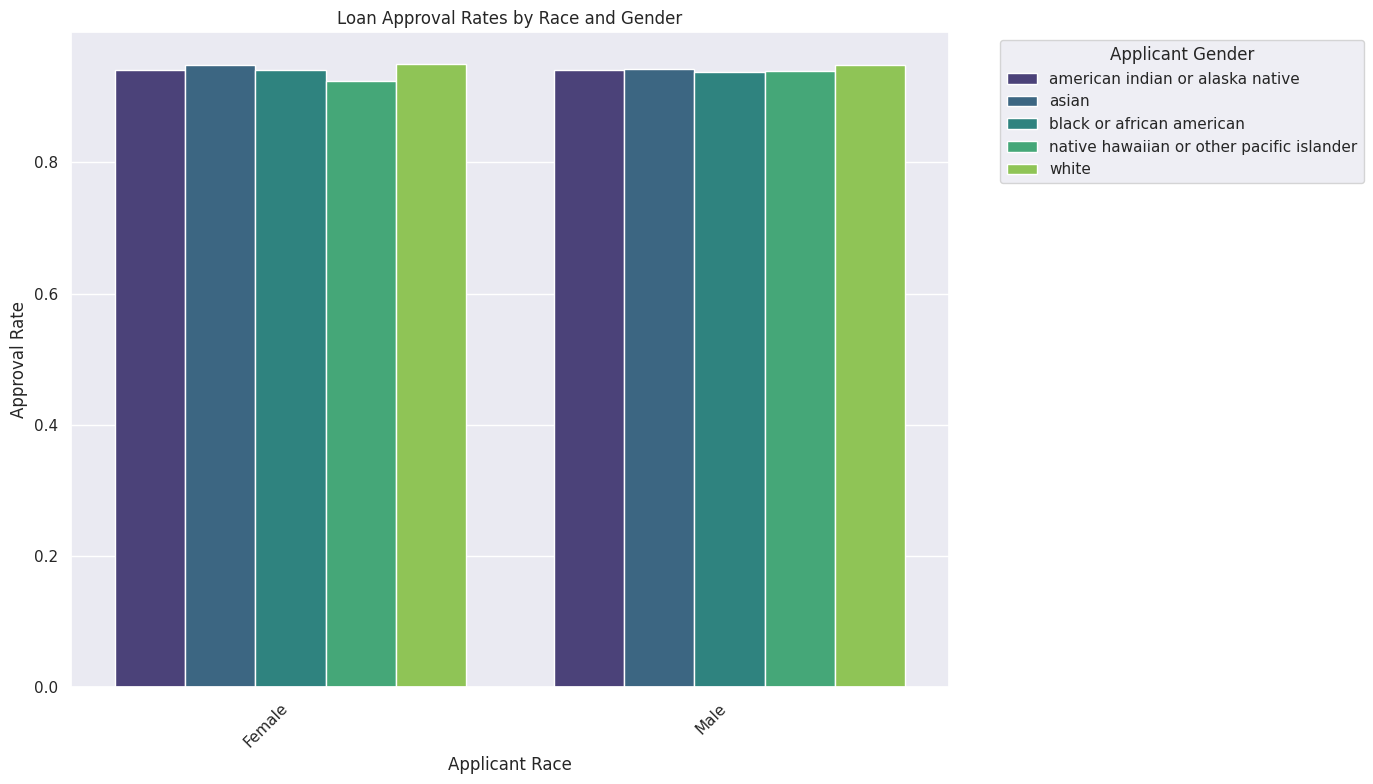

Saved: output/figures/loan_approval_rates_by_race_and_gender.png


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

plt.figure(figsize=(14, 8))
sns.barplot(x='gender', y='approval_rate', hue='derived_race', data=combined_approval_rates, palette='viridis')
plt.title('Loan Approval Rates by Race and Gender')
plt.xlabel('Applicant Race')
plt.ylabel('Approval Rate')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Applicant Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

safe_save_fig(f'{OUT_FIG_DIR}/loan_approval_rates_by_race_and_gender.png')

## 4) Mean Rate Spreads and Loan Metrics



### 4.a. Rate Distributions

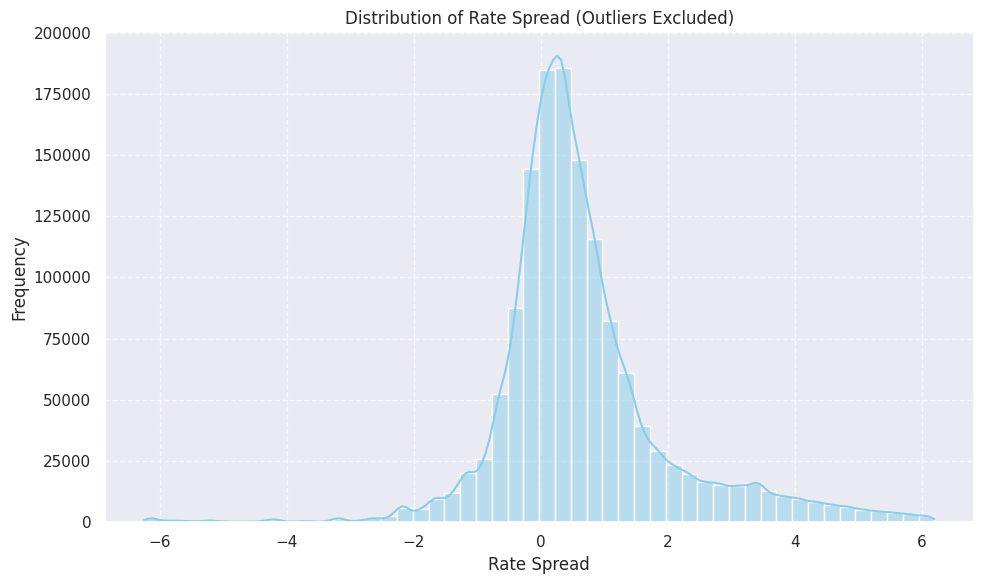

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['rate_spread'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Rate Spread (Outliers Excluded)')
plt.xlabel('Rate Spread')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2775036338.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Applicant Race', bbox_to_anchor=(1.05, 1), loc='upper left')


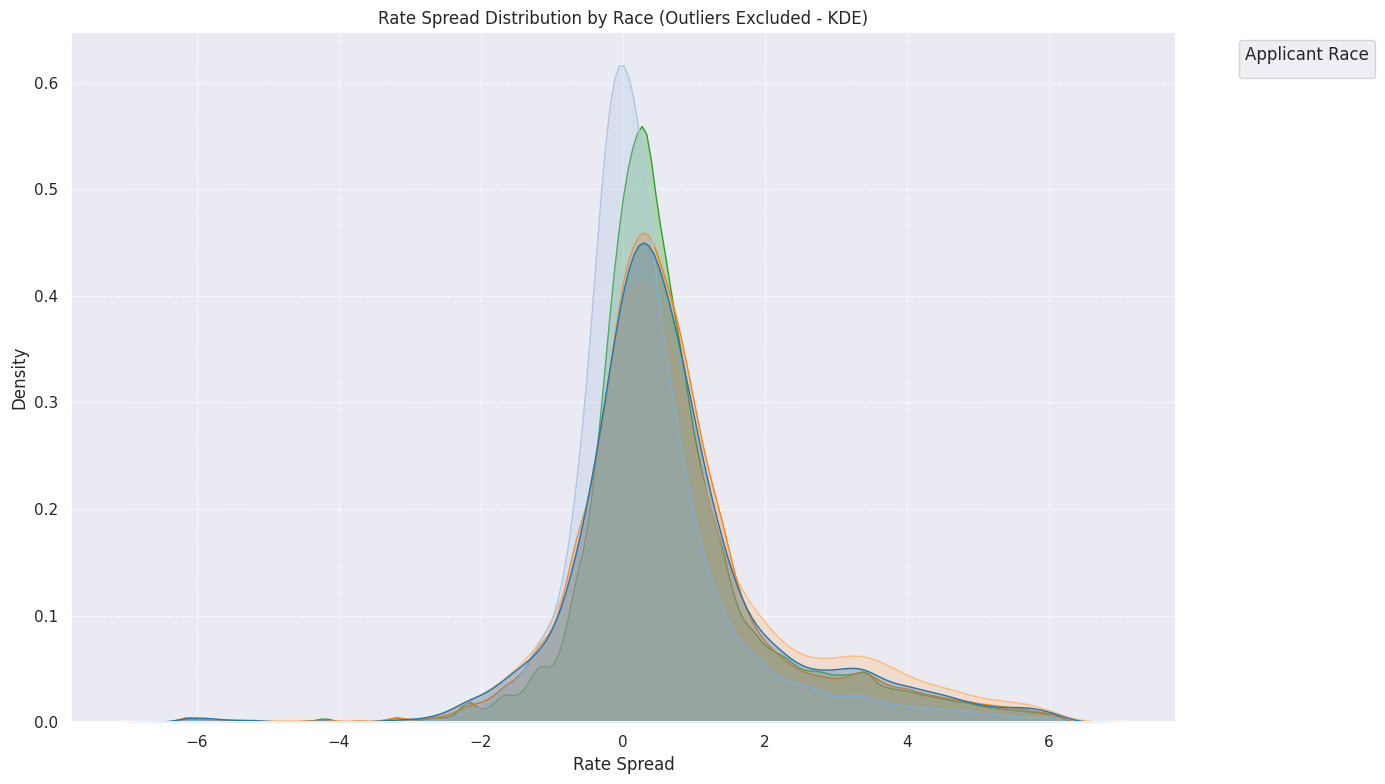

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.kdeplot(
    data=df_filtered,
    x='rate_spread',
    hue='derived_race', # Color by race
    fill=True,              # Fill the area under the density curve
    alpha=0.3,              # Transparency of the fill
    palette='tab20',        # Use a palette with more distinct colors
    common_norm=False       # Each density curve is normalized independently
)
plt.title('Rate Spread Distribution by Race (Outliers Excluded - KDE)')
plt.xlabel('Rate Spread')
plt.ylabel('Density')
plt.legend(title='Applicant Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 4.b. Calculate Metrics

In [ ]:

rate_spread_stats_women_by_race = df_women.groupby('derived_race', observed=False).agg(
    mean_rate_spread=('rate_spread', 'mean'),
    std_rate_spread=('rate_spread', 'std'),
    mean_loan_amount=('loan_amount', 'mean'),
    std_loan_amount=('loan_amount', 'std'),
    mean_debt_to_income_ratio=('debt_to_income_ratio', 'mean'),
    std_debt_to_income_ratio=('debt_to_income_ratio', 'std'),
    mean_loan_to_value_ratio=('loan_to_value_ratio', 'mean'),
    std_loan_to_value_ratio=('loan_to_value_ratio', 'std')
).reset_index()

print("Rate Spread and Loan Metrics Statistics for Women by Race:")
print(rate_spread_stats_women_by_race)

safe_save_csv(rate_spread_stats_women_by_race, f'{OUT_TAB_DIR}/rate_spread_stats_women_by_race.csv')

Rate Spread and Loan Metrics Statistics for Women by Race:
                                derived_race  mean_rate_spread  \
0           american indian or alaska native          0.693446   
1                                      asian          0.401724   
2                  black or african american          0.660140   
3  native hawaiian or other pacific islander          0.774095   
4                                      white          0.659540   

   std_rate_spread  mean_loan_amount  std_loan_amount  \
0         1.470181     224668.177697    159724.493466   
1         1.206793     370283.545670    221459.722500   
2         1.417999     234948.508503    158612.220332   
3         1.593770     245144.073346    180988.925144   
4         1.348715     230573.660479    168031.040561   

   mean_debt_to_income_ratio  std_debt_to_income_ratio  \
0                  43.178241                  3.957422   
1                  43.494263                  4.048022   
2                  43.32872

In [ ]:
# Merge approval rates and rate spread statistics
women_summary_stats_by_race = pd.merge(
    approval_rates_women_by_race,
    rate_spread_stats_women_by_race,
    on='derived_race',
    how='left'
)

print("Summary Statistics for Women by Race:")
print(women_summary_stats_by_race)

Summary Statistics for Women by Race:
                                derived_race  approval_rate  gender  \
0           american indian or alaska native       0.941432  Female   
1                                      asian       0.948570  Female   
2                  black or african american       0.941427  Female   
3  native hawaiian or other pacific islander       0.924034  Female   
4                                      white       0.950704  Female   

   mean_rate_spread  std_rate_spread  mean_loan_amount  std_loan_amount  \
0          0.693446         1.470181     224668.177697    159724.493466   
1          0.401724         1.206793     370283.545670    221459.722500   
2          0.660140         1.417999     234948.508503    158612.220332   
3          0.774095         1.593770     245144.073346    180988.925144   
4          0.659540         1.348715     230573.660479    168031.040561   

   mean_debt_to_income_ratio  std_debt_to_income_ratio  \
0                  43.1782

In [ ]:
print("Loan Amount Summary Statistics for Women by Race:")
print(women_summary_stats_by_race[['derived_race', 'mean_loan_amount', 'std_loan_amount']])

Loan Amount Summary Statistics for Women by Race:
                                derived_race  mean_loan_amount  \
0           american indian or alaska native     224668.177697   
1                                      asian     370283.545670   
2                  black or african american     234948.508503   
3  native hawaiian or other pacific islander     245144.073346   
4                                      white     230573.660479   

   std_loan_amount  
0    159724.493466  
1    221459.722500  
2    158612.220332  
3    180988.925144  
4    168031.040561  


In [ ]:
rate_spread_stats_men_by_race = df_men.groupby('derived_race', observed=False).agg(
    mean_rate_spread=('rate_spread', 'mean'),
    std_rate_spread=('rate_spread', 'std'),
    mean_loan_amount=('loan_amount', 'mean'),
    std_loan_amount=('loan_amount', 'std'),
    mean_debt_to_income_ratio=('debt_to_income_ratio', 'mean'),
    std_debt_to_income_ratio=('debt_to_income_ratio', 'std'),
    mean_loan_to_value_ratio=('loan_to_value_ratio', 'mean'),
    std_loan_to_value_ratio=('loan_to_value_ratio', 'std')
).reset_index()

print("Rate Spread and Loan Metrics Statistics for Men by Race:")
print(rate_spread_stats_men_by_race)

safe_save_csv(rate_spread_stats_men_by_race, f'{OUT_TAB_DIR}/rate_spread_stats_men_by_race.csv')

Rate Spread and Loan Metrics Statistics for Men by Race:
                                derived_race  mean_rate_spread  \
0           american indian or alaska native          0.708623   
1                                      asian          0.323947   
2                  black or african american          0.712307   
3  native hawaiian or other pacific islander          0.848184   
4                                      white          0.705996   

   std_rate_spread  mean_loan_amount  std_loan_amount  \
0         1.508911     243968.862275    166190.728487   
1         1.157406     422757.514958    237880.878259   
2         1.465288     257431.726242    176234.264998   
3         1.578626     262682.880123    200181.604738   
4         1.395015     263775.767931    191008.141280   

   mean_debt_to_income_ratio  std_debt_to_income_ratio  \
0                  43.130419                  3.979812   
1                  43.202549                  4.066690   
2                  43.154891 

### 4.c. Loan Characteristics of Approved Female Applicants


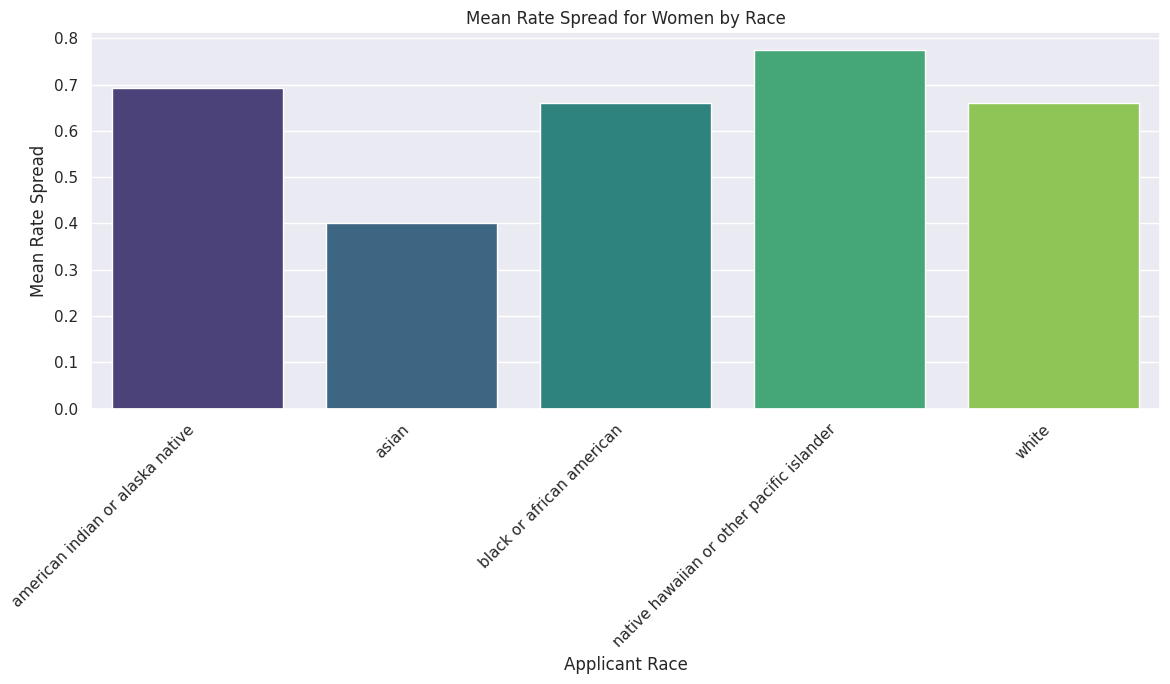

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.barplot(x='derived_race', y='mean_rate_spread', hue='derived_race', data=rate_spread_stats_women_by_race, palette='viridis', legend=False)
plt.title('Mean Rate Spread for Women by Race')
plt.xlabel('Applicant Race')
plt.ylabel('Mean Rate Spread')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

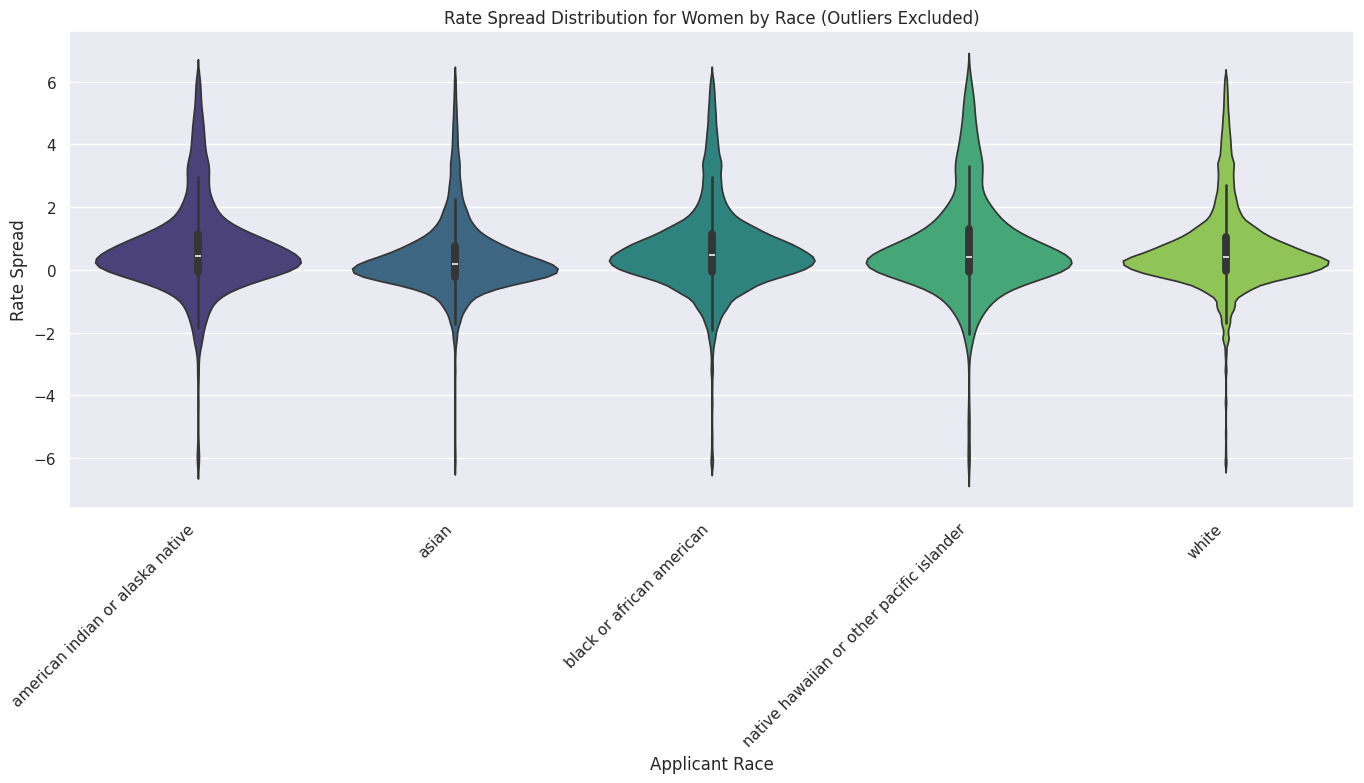

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.violinplot(x='derived_race', y='rate_spread', hue='derived_race', data=df_women, palette='viridis', legend=False)
plt.title('Rate Spread Distribution for Women by Race (Outliers Excluded)')
plt.xlabel('Applicant Race')
plt.ylabel('Rate Spread')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Loan Characteristics

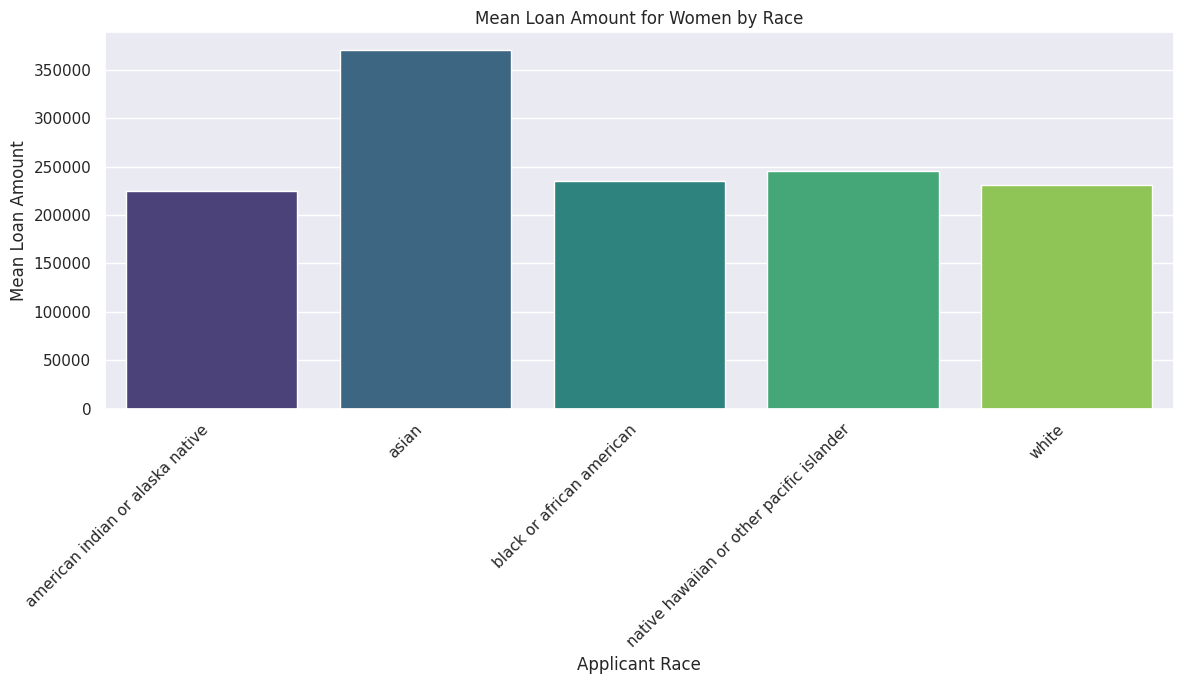

Saved: output/figures/mean_loan_amount_women_by_race.png


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

plt.figure(figsize=(12, 7))
sns.barplot(x='derived_race', y='mean_loan_amount', hue='derived_race', data=women_summary_stats_by_race, palette='viridis', legend=False)
plt.title('Mean Loan Amount for Women by Race')
plt.xlabel('Applicant Race')
plt.ylabel('Mean Loan Amount')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

safe_save_fig(f'{OUT_FIG_DIR}/mean_loan_amount_women_by_race.png')

### 4.d. Loan Characteristics of Approved Male Applicants


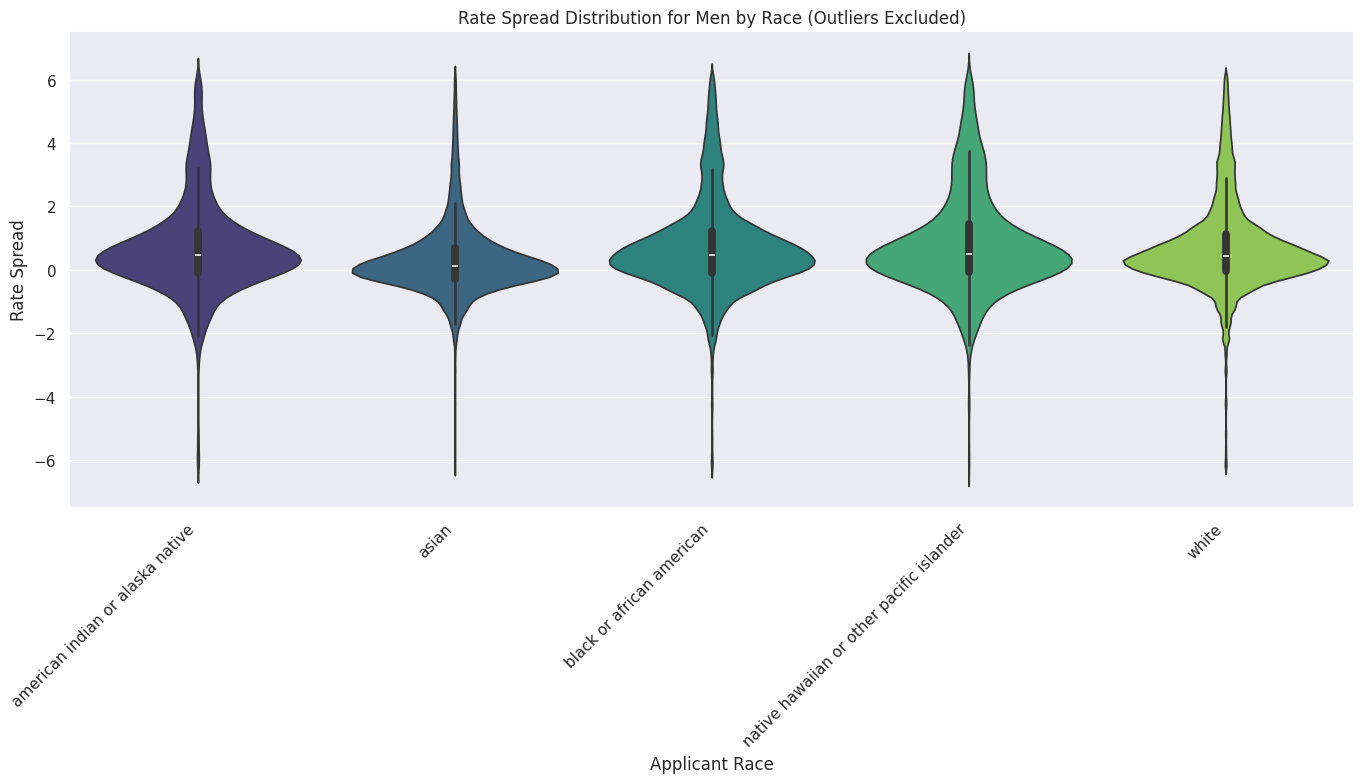

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.violinplot(x='derived_race', y='rate_spread', hue='derived_race', data=df_men, palette='viridis', legend=False)
plt.title('Rate Spread Distribution for Men by Race (Outliers Excluded)')
plt.xlabel('Applicant Race')
plt.ylabel('Rate Spread')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

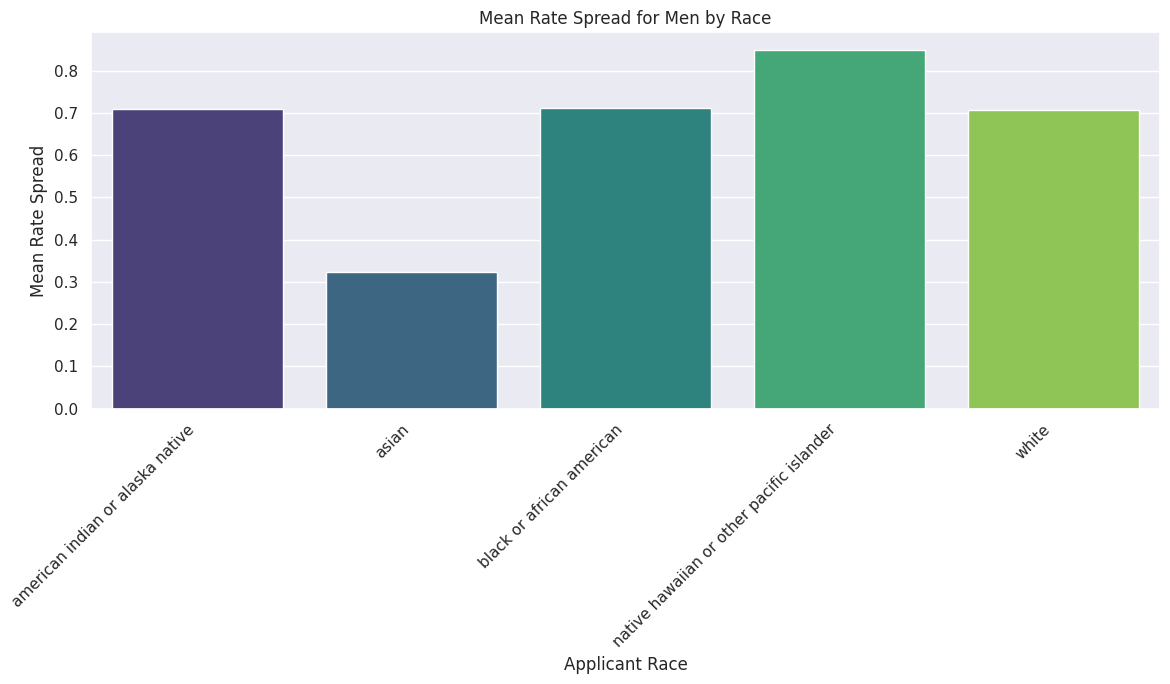

Saved: output/figures/mean_rate_spread_men_by_race.png


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.barplot(x='derived_race', y='mean_rate_spread', hue='derived_race', data=rate_spread_stats_men_by_race, palette='viridis', legend=False)
plt.title('Mean Rate Spread for Men by Race')
plt.xlabel('Applicant Race')
plt.ylabel('Mean Rate Spread')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

safe_save_fig(f'{OUT_FIG_DIR}/mean_rate_spread_men_by_race.png')

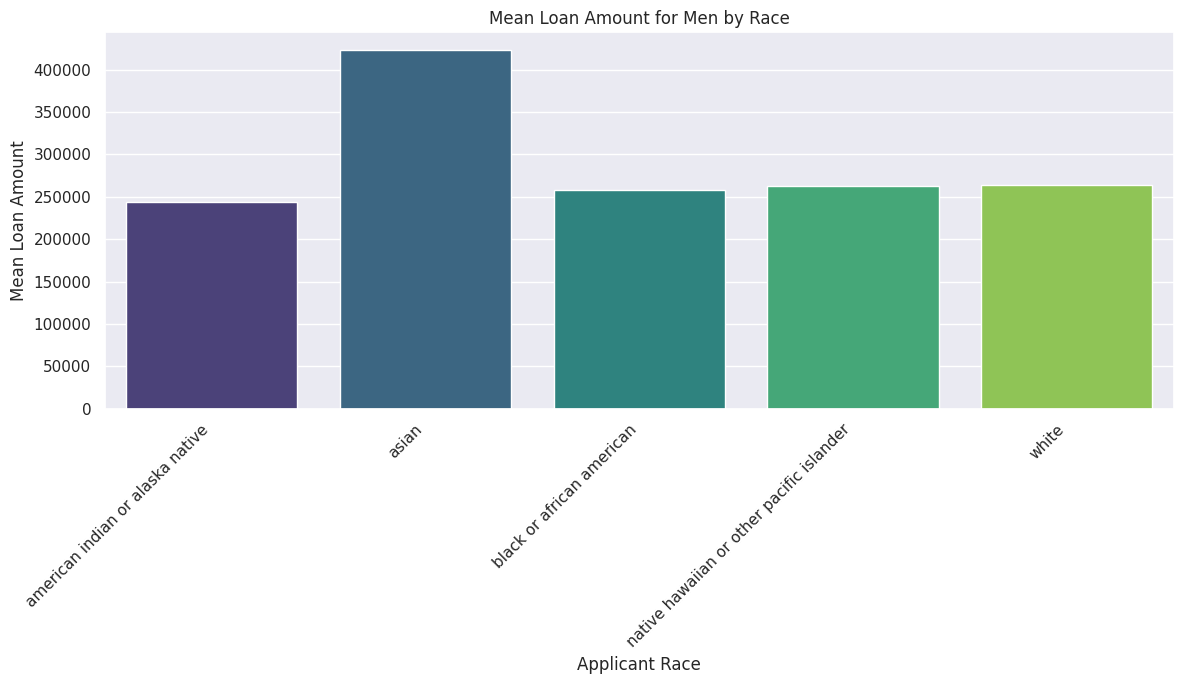

Saved: output/figures/mean_loan_amount_men_by_race.png


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.barplot(x='derived_race', y='mean_loan_amount', hue='derived_race', data=rate_spread_stats_men_by_race, palette='viridis', legend=False)
plt.title('Mean Loan Amount for Men by Race')
plt.xlabel('Applicant Race')
plt.ylabel('Mean Loan Amount')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

safe_save_fig(f'{OUT_FIG_DIR}/mean_loan_amount_men_by_race.png')

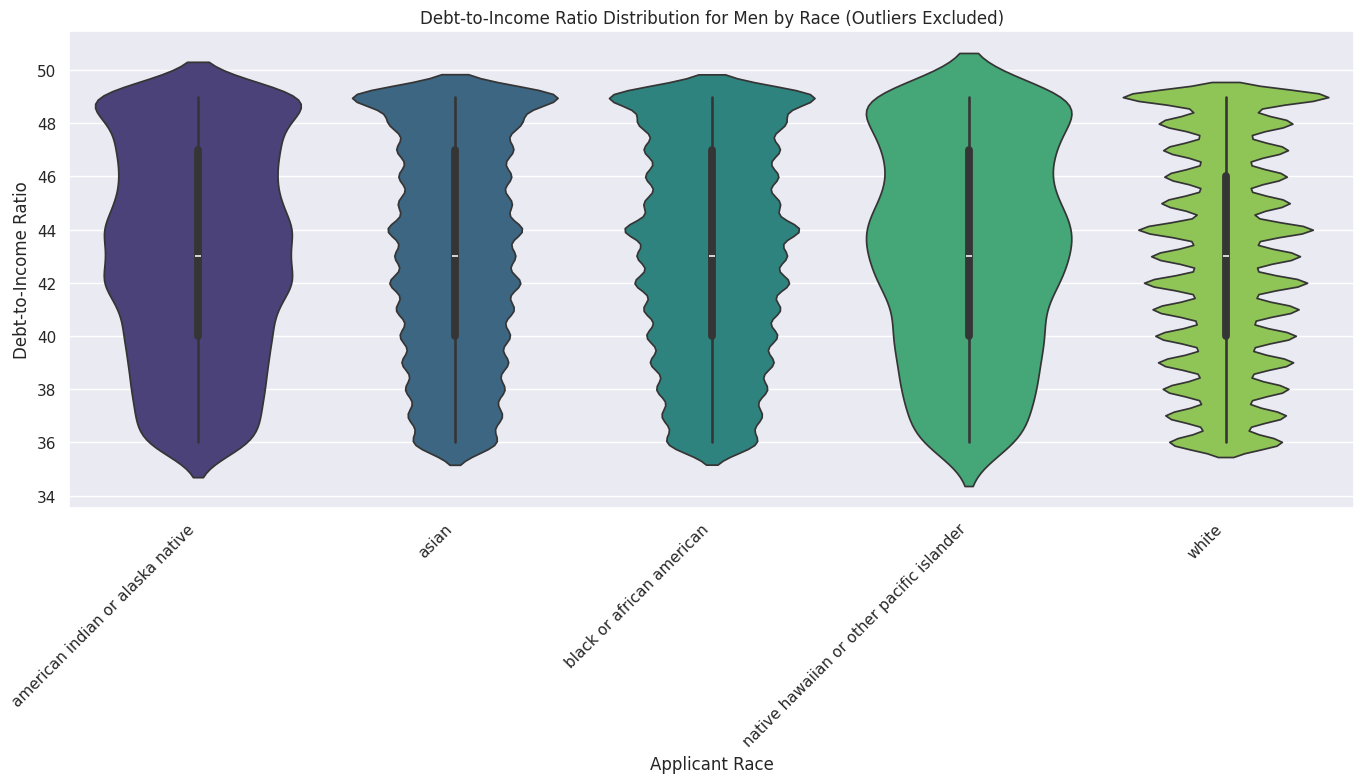

Saved: output/figures/dti_distribution_men_by_race.png


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

plt.figure(figsize=(14, 8))
sns.violinplot(x='derived_race', y='debt_to_income_ratio', hue='derived_race', data=df_men, palette='viridis', legend=False)
plt.title('Debt-to-Income Ratio Distribution for Men by Race (Outliers Excluded)')
plt.xlabel('Applicant Race')
plt.ylabel('Debt-to-Income Ratio')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

safe_save_fig(f'{OUT_FIG_DIR}/dti_distribution_men_by_race.png')

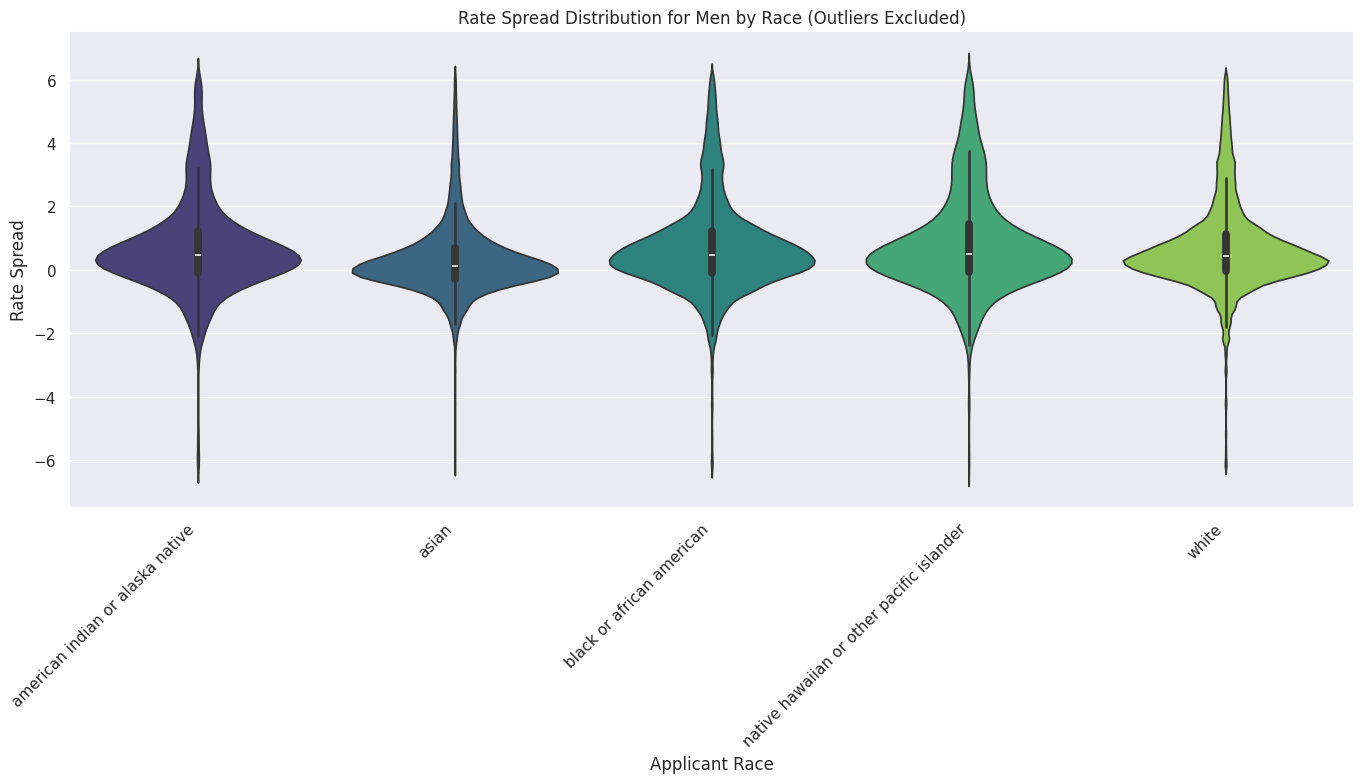

Saved: output/figures/rate_spread_distribution_men_by_race.png


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

plt.figure(figsize=(14, 8))
sns.violinplot(x='derived_race', y='rate_spread', hue='derived_race', data=df_men, palette='viridis', legend=False)
plt.title('Rate Spread Distribution for Men by Race (Outliers Excluded)')
plt.xlabel('Applicant Race')
plt.ylabel('Rate Spread')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

safe_save_fig(f'{OUT_FIG_DIR}/rate_spread_distribution_men_by_race.png')

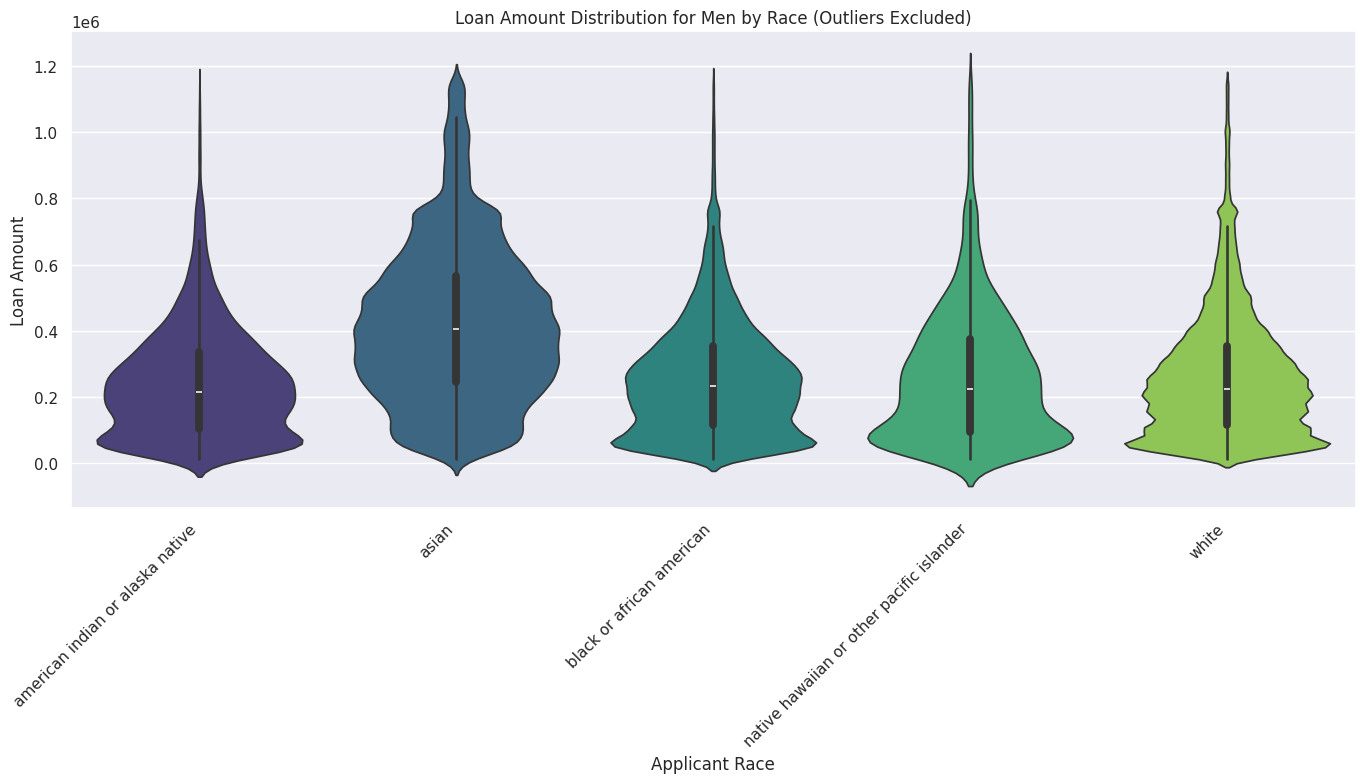

Saved: output/figures/loan_amount_distribution_men_by_race.png


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

plt.figure(figsize=(14, 8))
sns.violinplot(x='derived_race', y='loan_amount', hue='derived_race', data=df_men, palette='viridis', legend=False)
plt.title('Loan Amount Distribution for Men by Race (Outliers Excluded)')
plt.xlabel('Applicant Race')
plt.ylabel('Loan Amount')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

safe_save_fig(f'{OUT_FIG_DIR}/loan_amount_distribution_men_by_race.png')

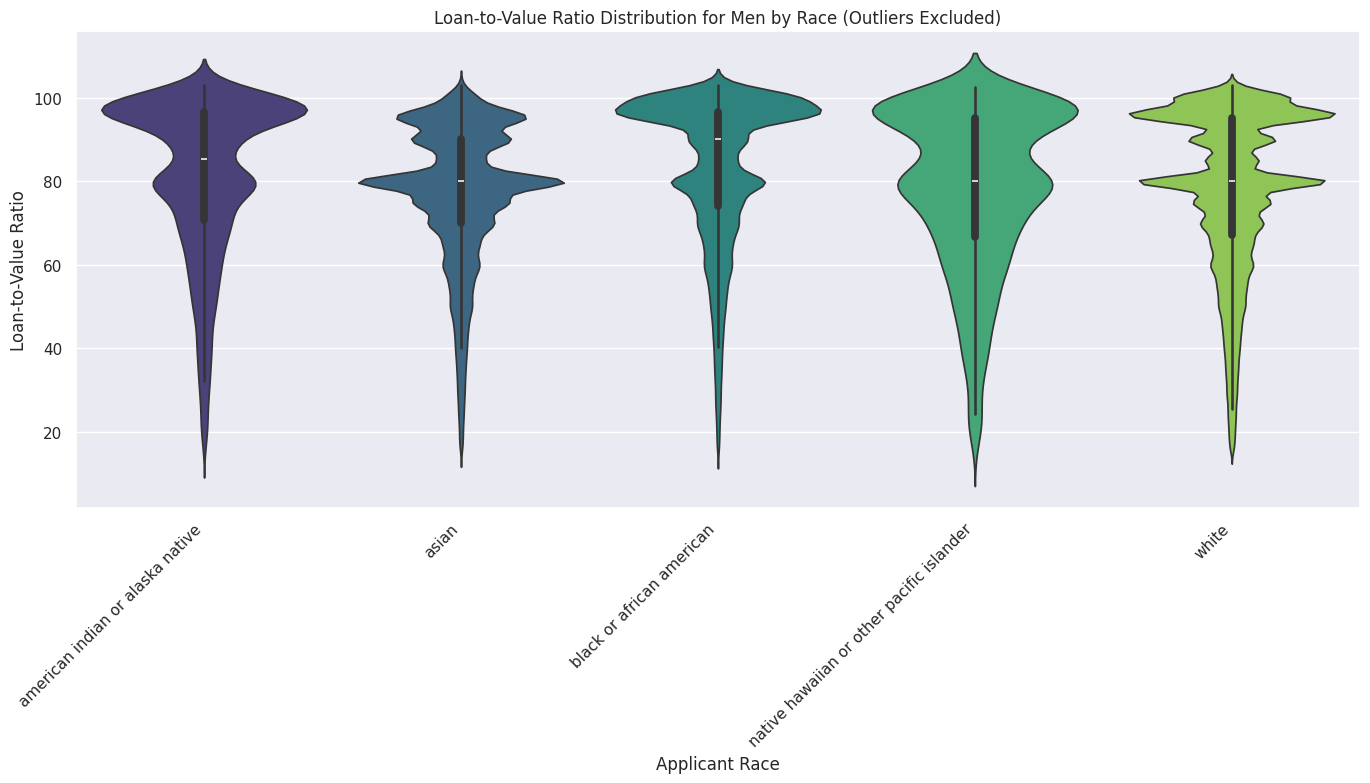

Saved: output/figures/ltv_distribution_men_by_race.png


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

plt.figure(figsize=(14, 8))
sns.violinplot(x='derived_race', y='loan_to_value_ratio', hue='derived_race', data=df_men, palette='viridis', legend=False)
plt.title('Loan-to-Value Ratio Distribution for Men by Race (Outliers Excluded)')
plt.xlabel('Applicant Race')
plt.ylabel('Loan-to-Value Ratio')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

safe_save_fig(f'{OUT_FIG_DIR}/ltv_distribution_men_by_race.png')

## 5) Visualizing Distruibtrions (KDE Plots)

This next visualization is helpful to better understand the background of loan applicants as a way to better understand the rate_spread offered to applicants. The 2D Kernel Density Estimate (KDE) plots provide a richer understanding of the joint distribution of `rate_spread` and `debt_to_income_ratios` across race and gender.

These plots allow a visual comparison of the entire distribution, not just the mean, which is helpful to visualize differences in applicant profiles.


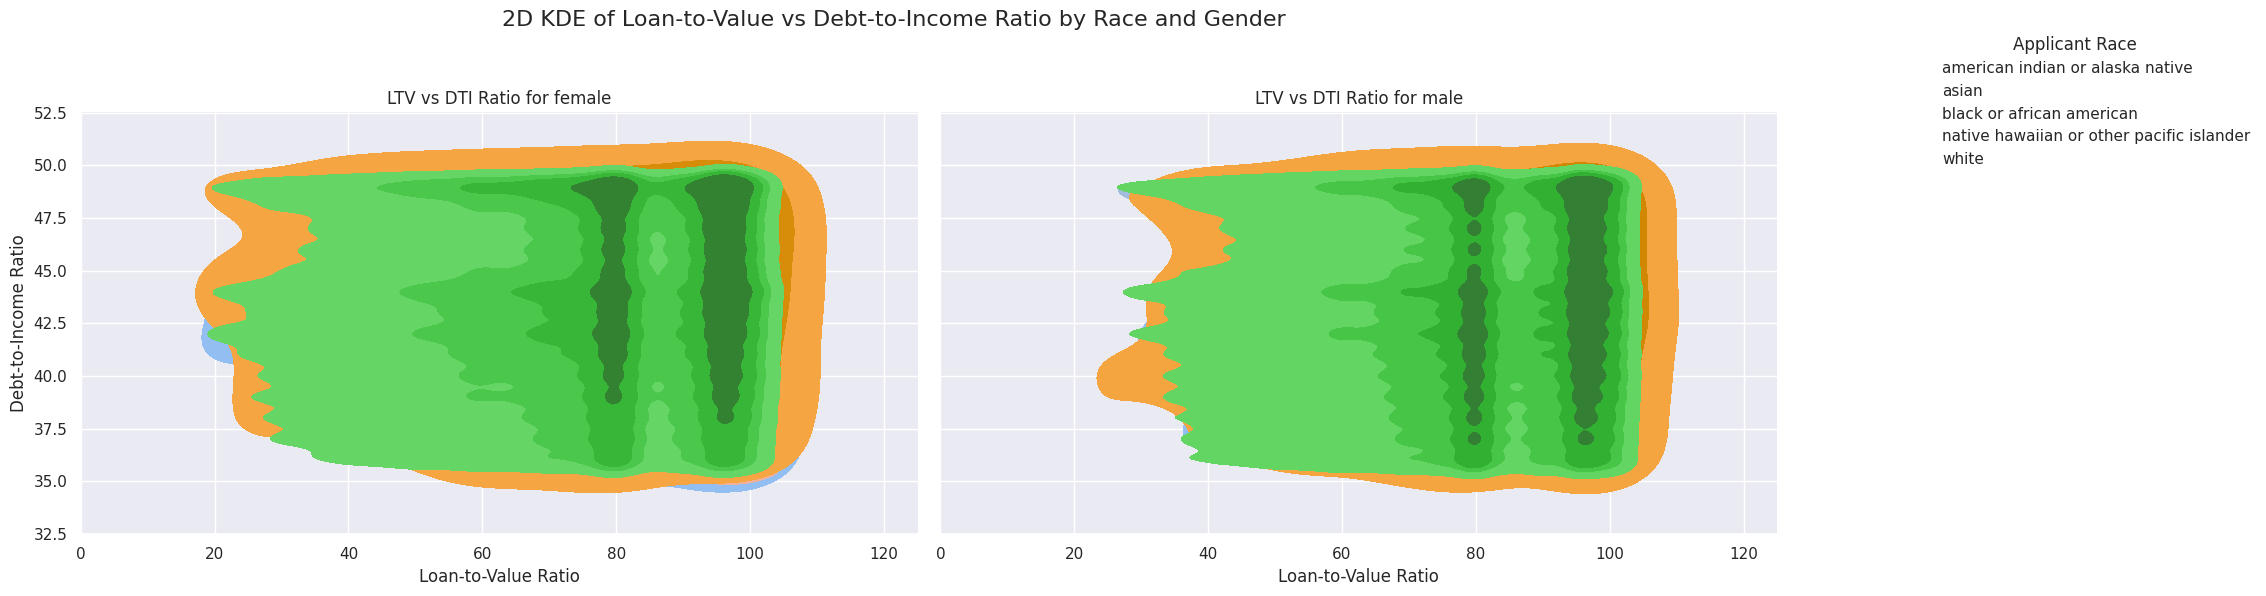

Saved: output/figures/kde_ltv_dti_race_gender.png


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

g = sns.FacetGrid(df_filtered, col="derived_sex", hue="derived_race", height=6, aspect=1.2, col_wrap=2, palette="tab20")
g.map(sns.kdeplot, "loan_to_value_ratio", "debt_to_income_ratio", fill=True, levels=5)
g.add_legend(title='Applicant Race', bbox_to_anchor=(1.05, 1), loc='upper left')

for ax in g.axes.flat:
    ax.set_title(f'LTV vs DTI Ratio for {ax.get_title().split("=")[1].strip()}')
    ax.set_xlabel('Loan-to-Value Ratio')
    ax.set_ylabel('Debt-to-Income Ratio')

plt.xlim(0, 125) # Set x-axis limit for loan_to_value_ratio

plt.suptitle('2D KDE of Loan-to-Value vs Debt-to-Income Ratio by Race and Gender', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

safe_save_fig(f'{OUT_FIG_DIR}/kde_ltv_dti_race_gender.png')

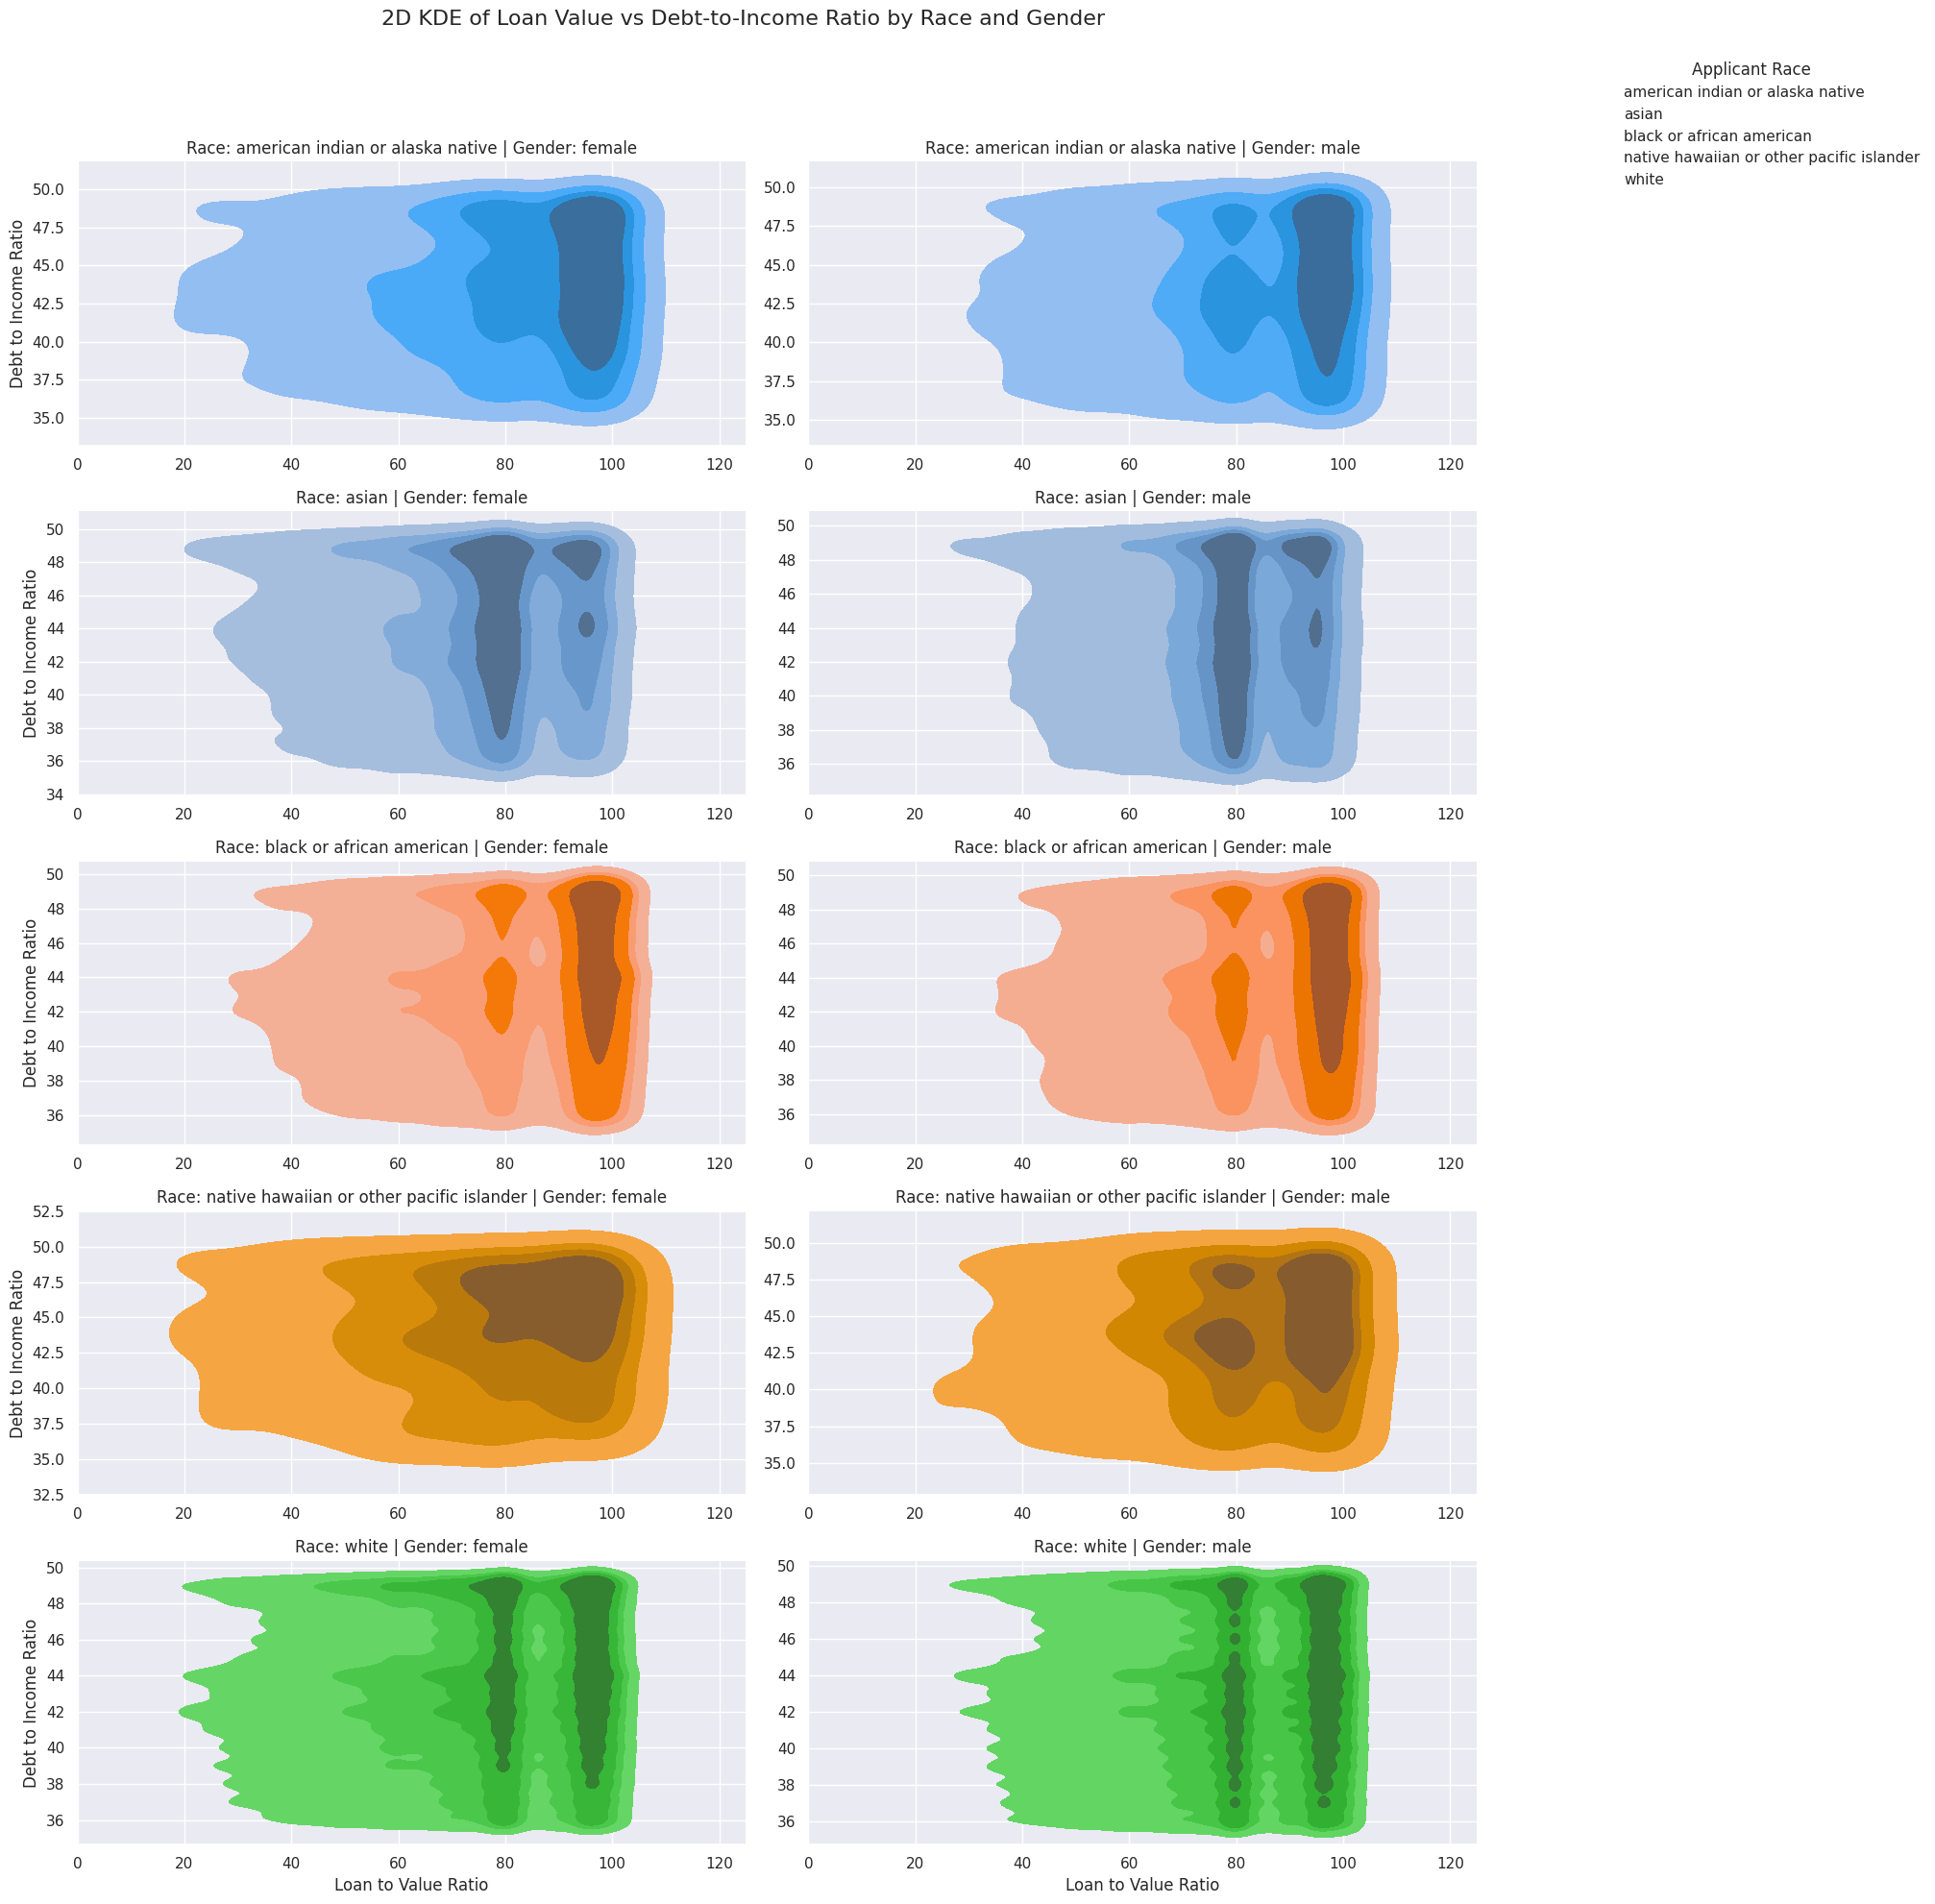

Saved: output/figures/kde_rate_spread_dti_race_gender_grid.png


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

g = sns.FacetGrid(df_filtered, row="derived_race", col="derived_sex", height=4, aspect=1.5, hue="derived_race", palette="tab20", sharex=False, sharey=False)
g.map(sns.kdeplot, "loan_to_value_ratio", "debt_to_income_ratio", fill=True, levels=5) # Removed hue='derived_race'
g.add_legend(title='Applicant Race', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set titles for each facet correctly using row_name and col_name
g.set_titles(row_template='Race: {row_name}', col_template='Gender: {col_name}')

# Set common x and y labels if needed, otherwise FacetGrid handles it
g.set_xlabels('Loan to Value Ratio')
g.set_ylabels('Debt to Income Ratio')

# Set x-axis limit for loan_to_value_ratio on all subplots
for ax in g.axes.flat:
    ax.set_xlim(0, 125) # Fixed LTV x-axis range

plt.suptitle('2D KDE of Loan Value vs Debt-to-Income Ratio by Race and Gender', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

#These are not printing correctly and show up as white space. Need to manually save from console. Need to be fixed
safe_save_fig(f'{OUT_FIG_DIR}/kde_rate_spread_dti_race_gender_grid.png')

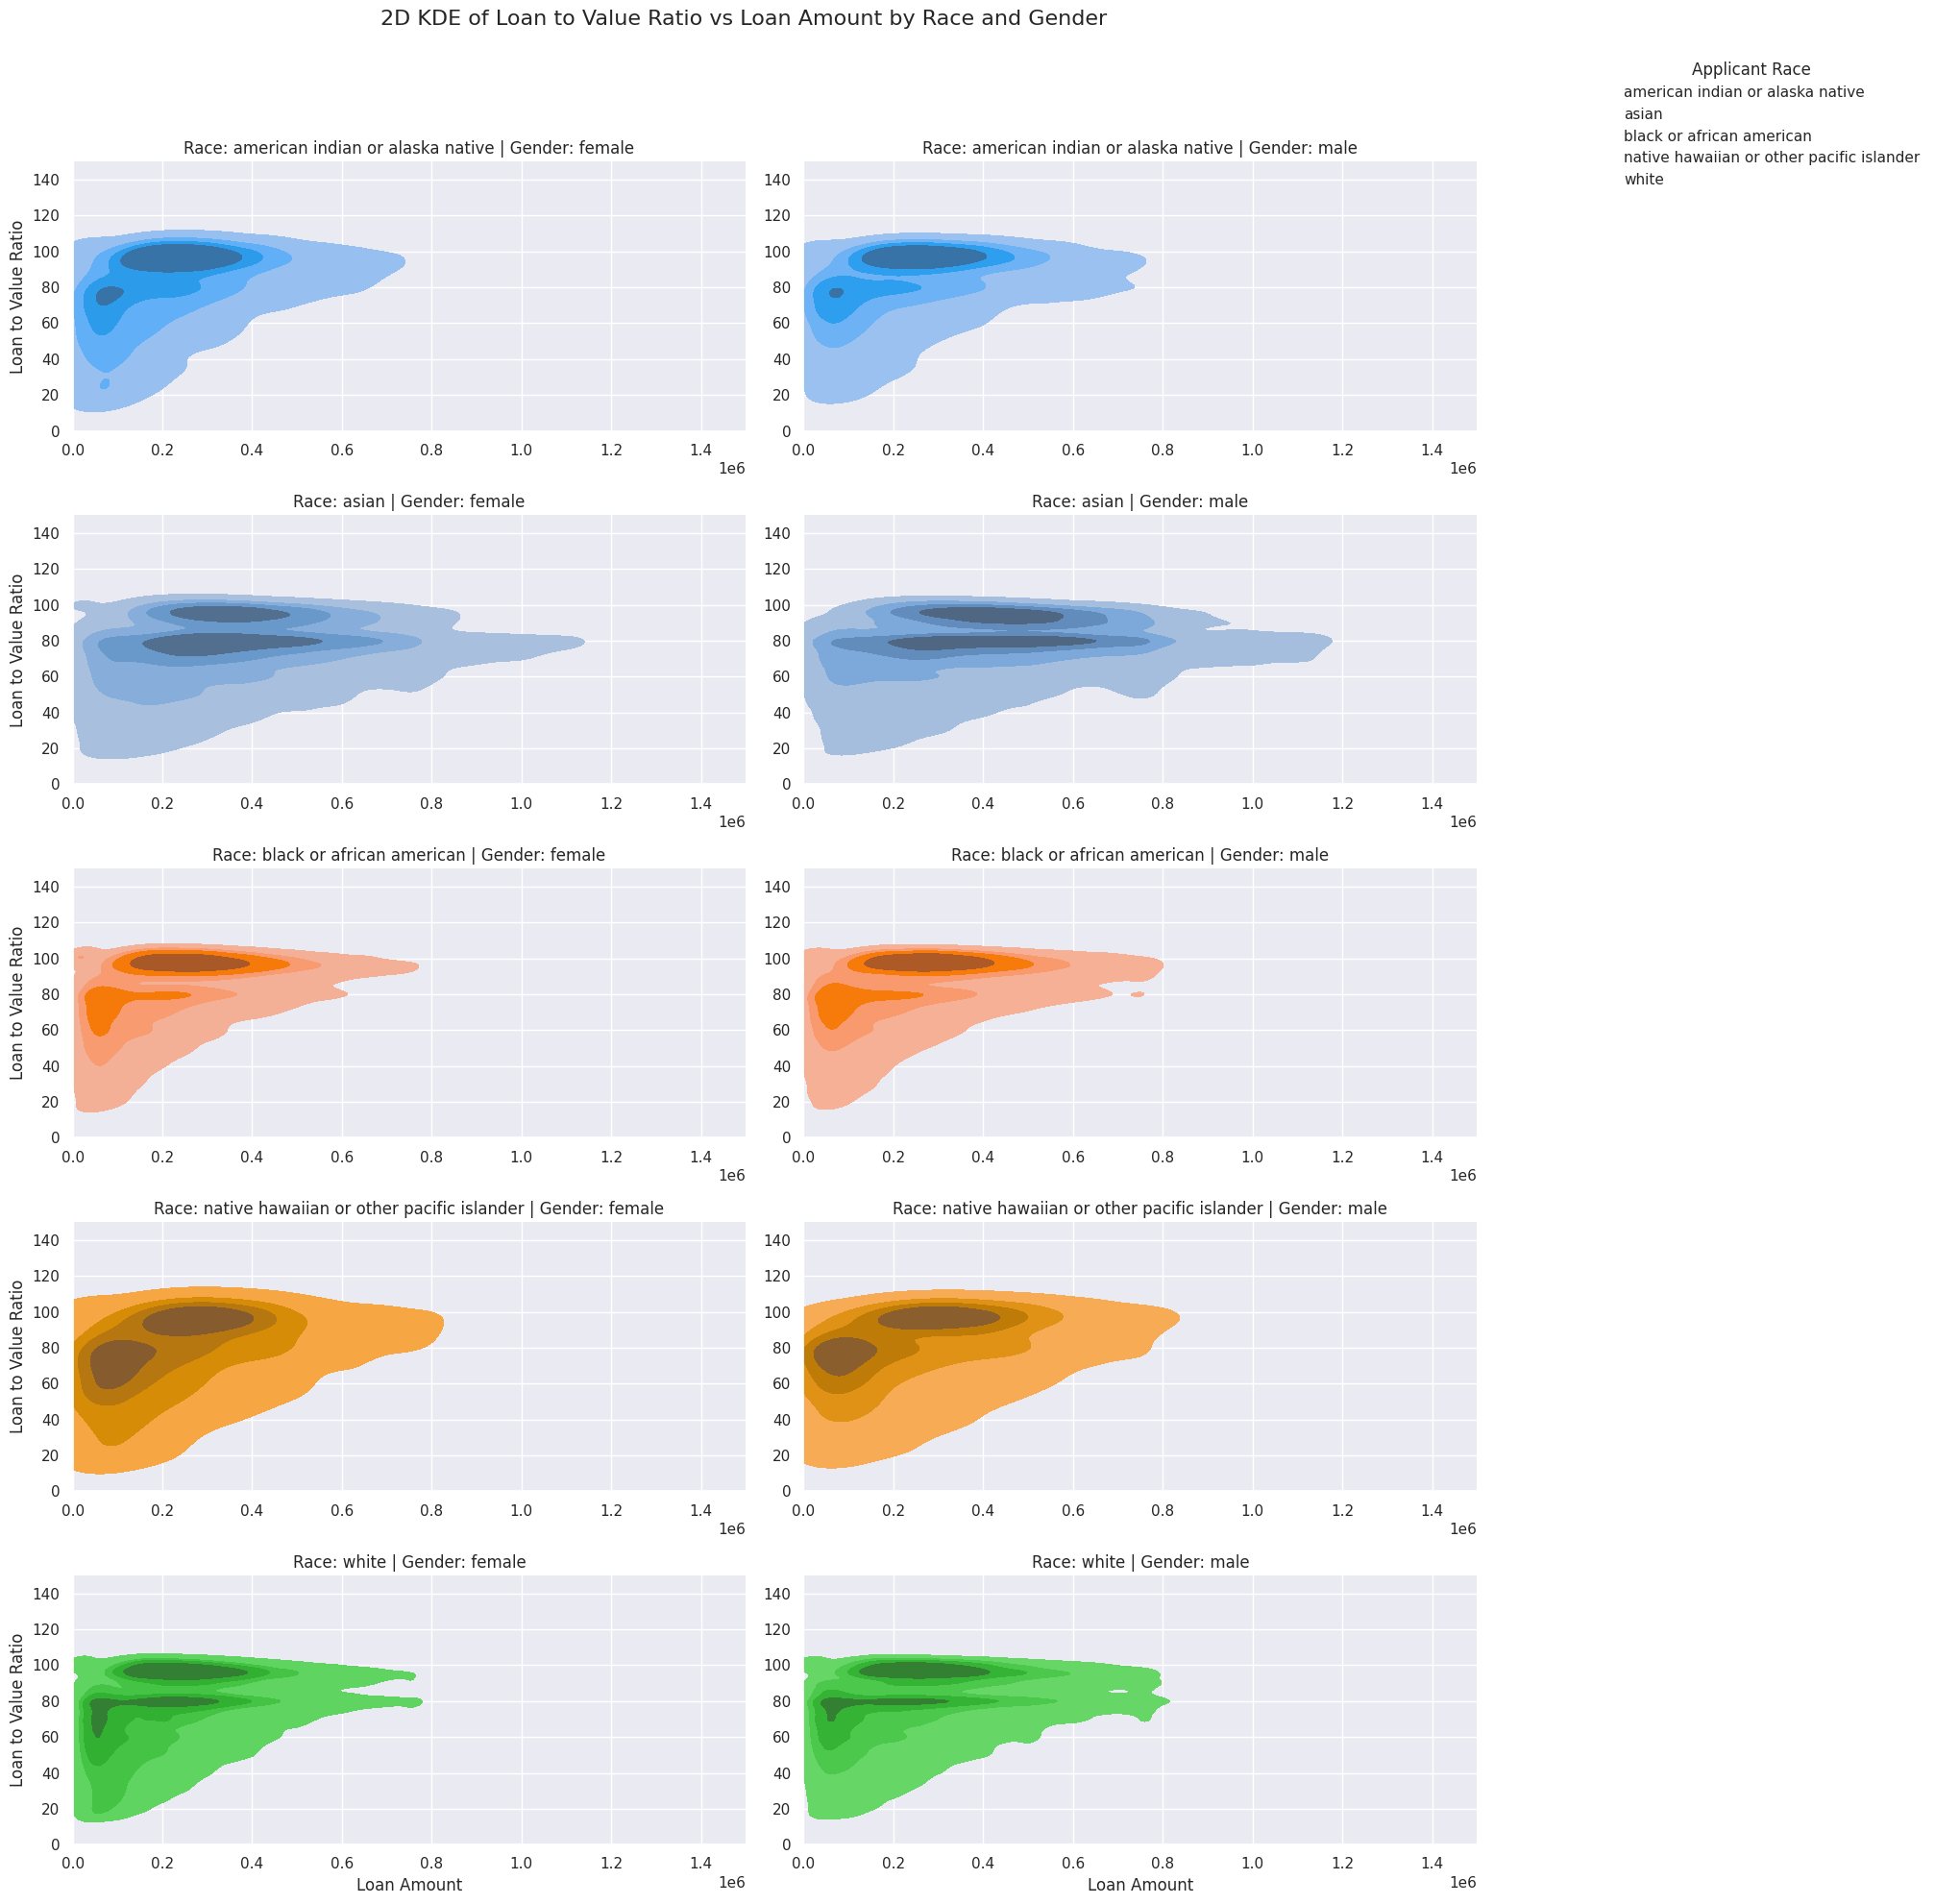

Saved: output/figures/kde_rate_spread_l2v_race_gender_grid.png


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

g = sns.FacetGrid(df_filtered, row="derived_race", col="derived_sex", height=4, aspect=1.5, hue="derived_race", palette="tab20", sharex=False, sharey=False)
g.map(sns.kdeplot, "loan_amount", "loan_to_value_ratio", fill=True, levels=5) # Removed hue='derived_race'
g.add_legend(title='Applicant Race', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set titles for each facet correctly using row_name and col_name
g.set_titles(row_template='Race: {row_name}', col_template='Gender: {col_name}')

# Set common x and y labels if needed, otherwise FacetGrid handles it
g.set_xlabels('Loan Amount')
g.set_ylabels('Loan to Value Ratio')

# Set y-axis limit for loan_to_value_ratio and x-axis for loan_amount on all subplots
for ax in g.axes.flat:
    ax.set_ylim(0, 150) # Fixed LTV y-axis range
    ax.set_xlim(0, 1_500_000) # Fixed Loan Amount x-axis range (e.g., up to 1.5 million)

plt.suptitle('2D KDE of Loan to Value Ratio vs Loan Amount by Race and Gender', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

#These are not printing correctly and show up as white space. Need to manually save from console. Need to be fixed
safe_save_fig(f'{OUT_FIG_DIR}/kde_rate_spread_l2v_race_gender_grid.png')

## 6) Comparison of Mean Rate Spreads & Loan Characteristics

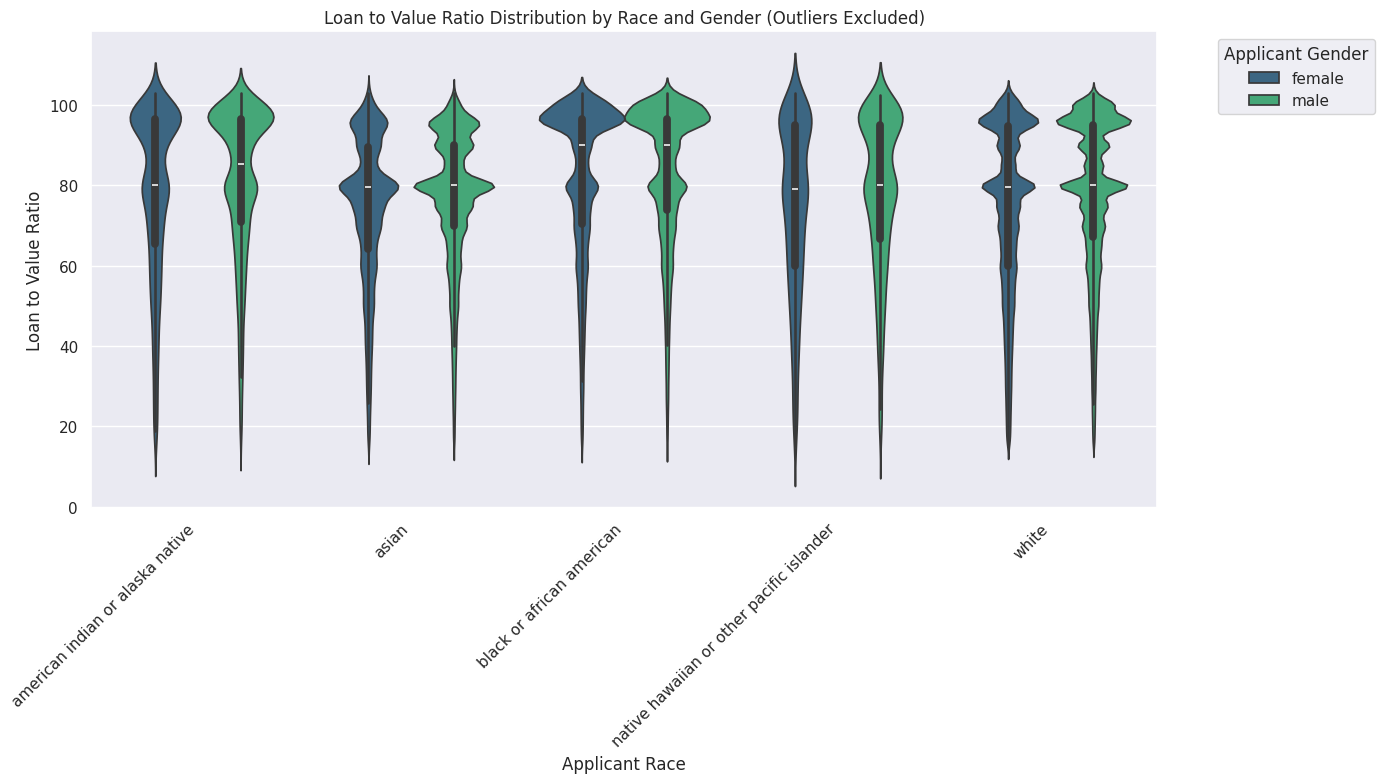

Saved: output/figures/ltv_distribution_race_gender_violin.png


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

plt.figure(figsize=(14, 8))
sns.violinplot(x='derived_race', y='loan_to_value_ratio', hue='derived_sex', data=df_filtered, palette='viridis')
plt.title('Loan to Value Ratio Distribution by Race and Gender (Outliers Excluded)')
plt.xlabel('Applicant Race')
plt.ylabel('Loan to Ratio')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Applicant Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

safe_save_fig(f'{OUT_FIG_DIR}/dti_distribution_race_gender_violin.png')

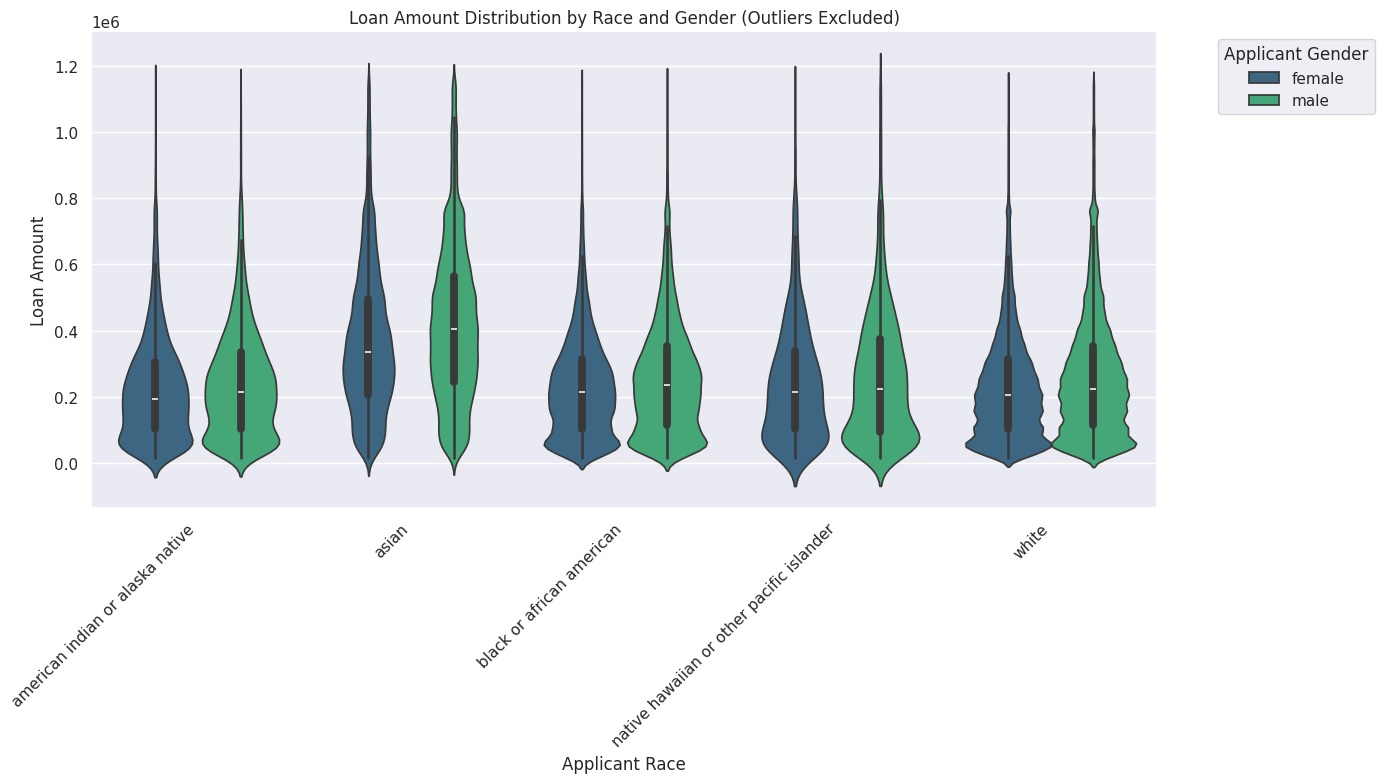

Saved: output/figures/loanamount_distribution_race_gender_violin.png


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

plt.figure(figsize=(14, 8))
sns.violinplot(x='derived_race', y='loan_amount', hue='derived_sex', data=df_filtered, palette='viridis')
plt.title('Loan Amount Distribution by Race and Gender (Outliers Excluded)')
plt.xlabel('Applicant Race')
plt.ylabel('Loan Amount')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Applicant Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

safe_save_fig(f'{OUT_FIG_DIR}/loanamount_distribution_race_gender_violin.png')

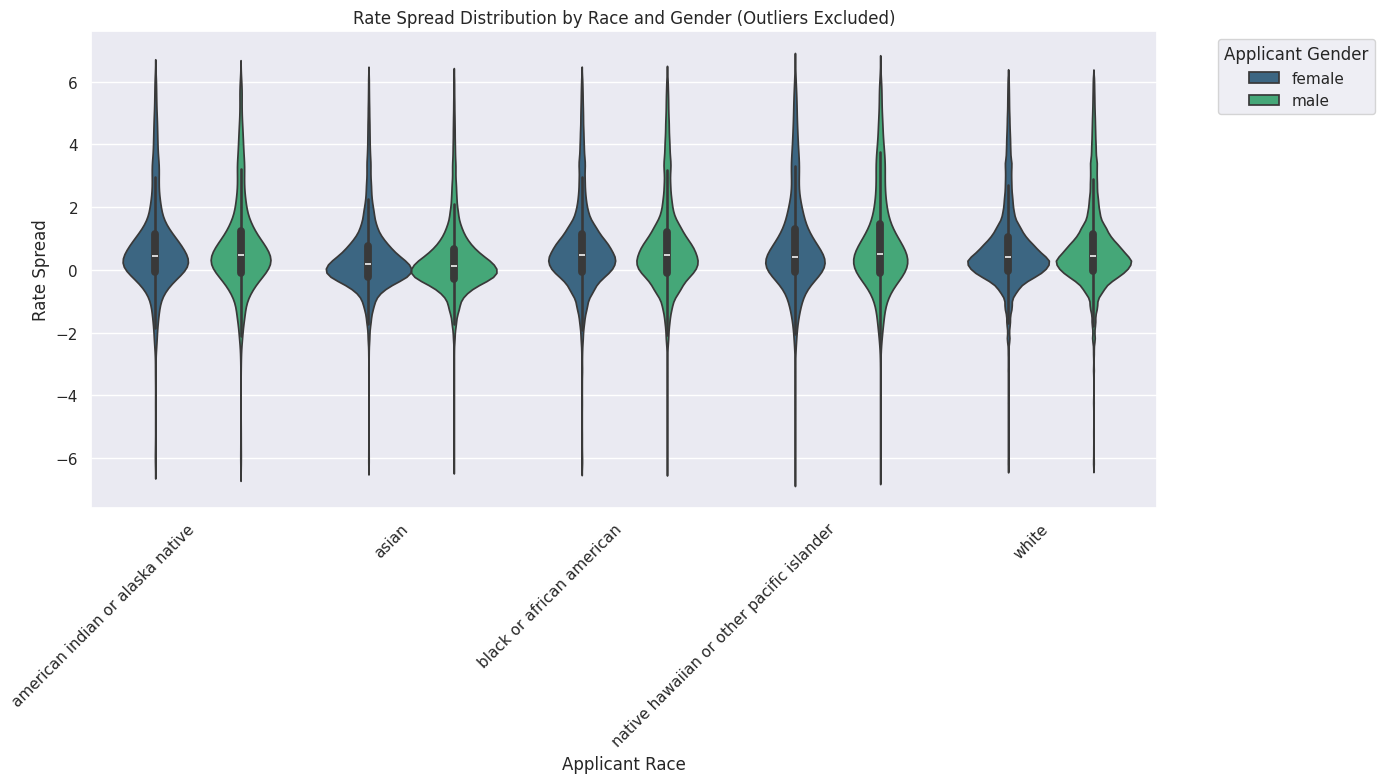

Saved: output/figures/ratespread_distribution_race_gender_violin.png


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

plt.figure(figsize=(14, 8))
sns.violinplot(x='derived_race', y='rate_spread', hue='derived_sex', data=df_filtered, palette='viridis')
plt.title('Rate Spread Distribution by Race and Gender (Outliers Excluded)')
plt.xlabel('Applicant Race')
plt.ylabel('Rate Spread')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Applicant Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

safe_save_fig(f'{OUT_FIG_DIR}/ratespread_distribution_race_gender_violin.png')

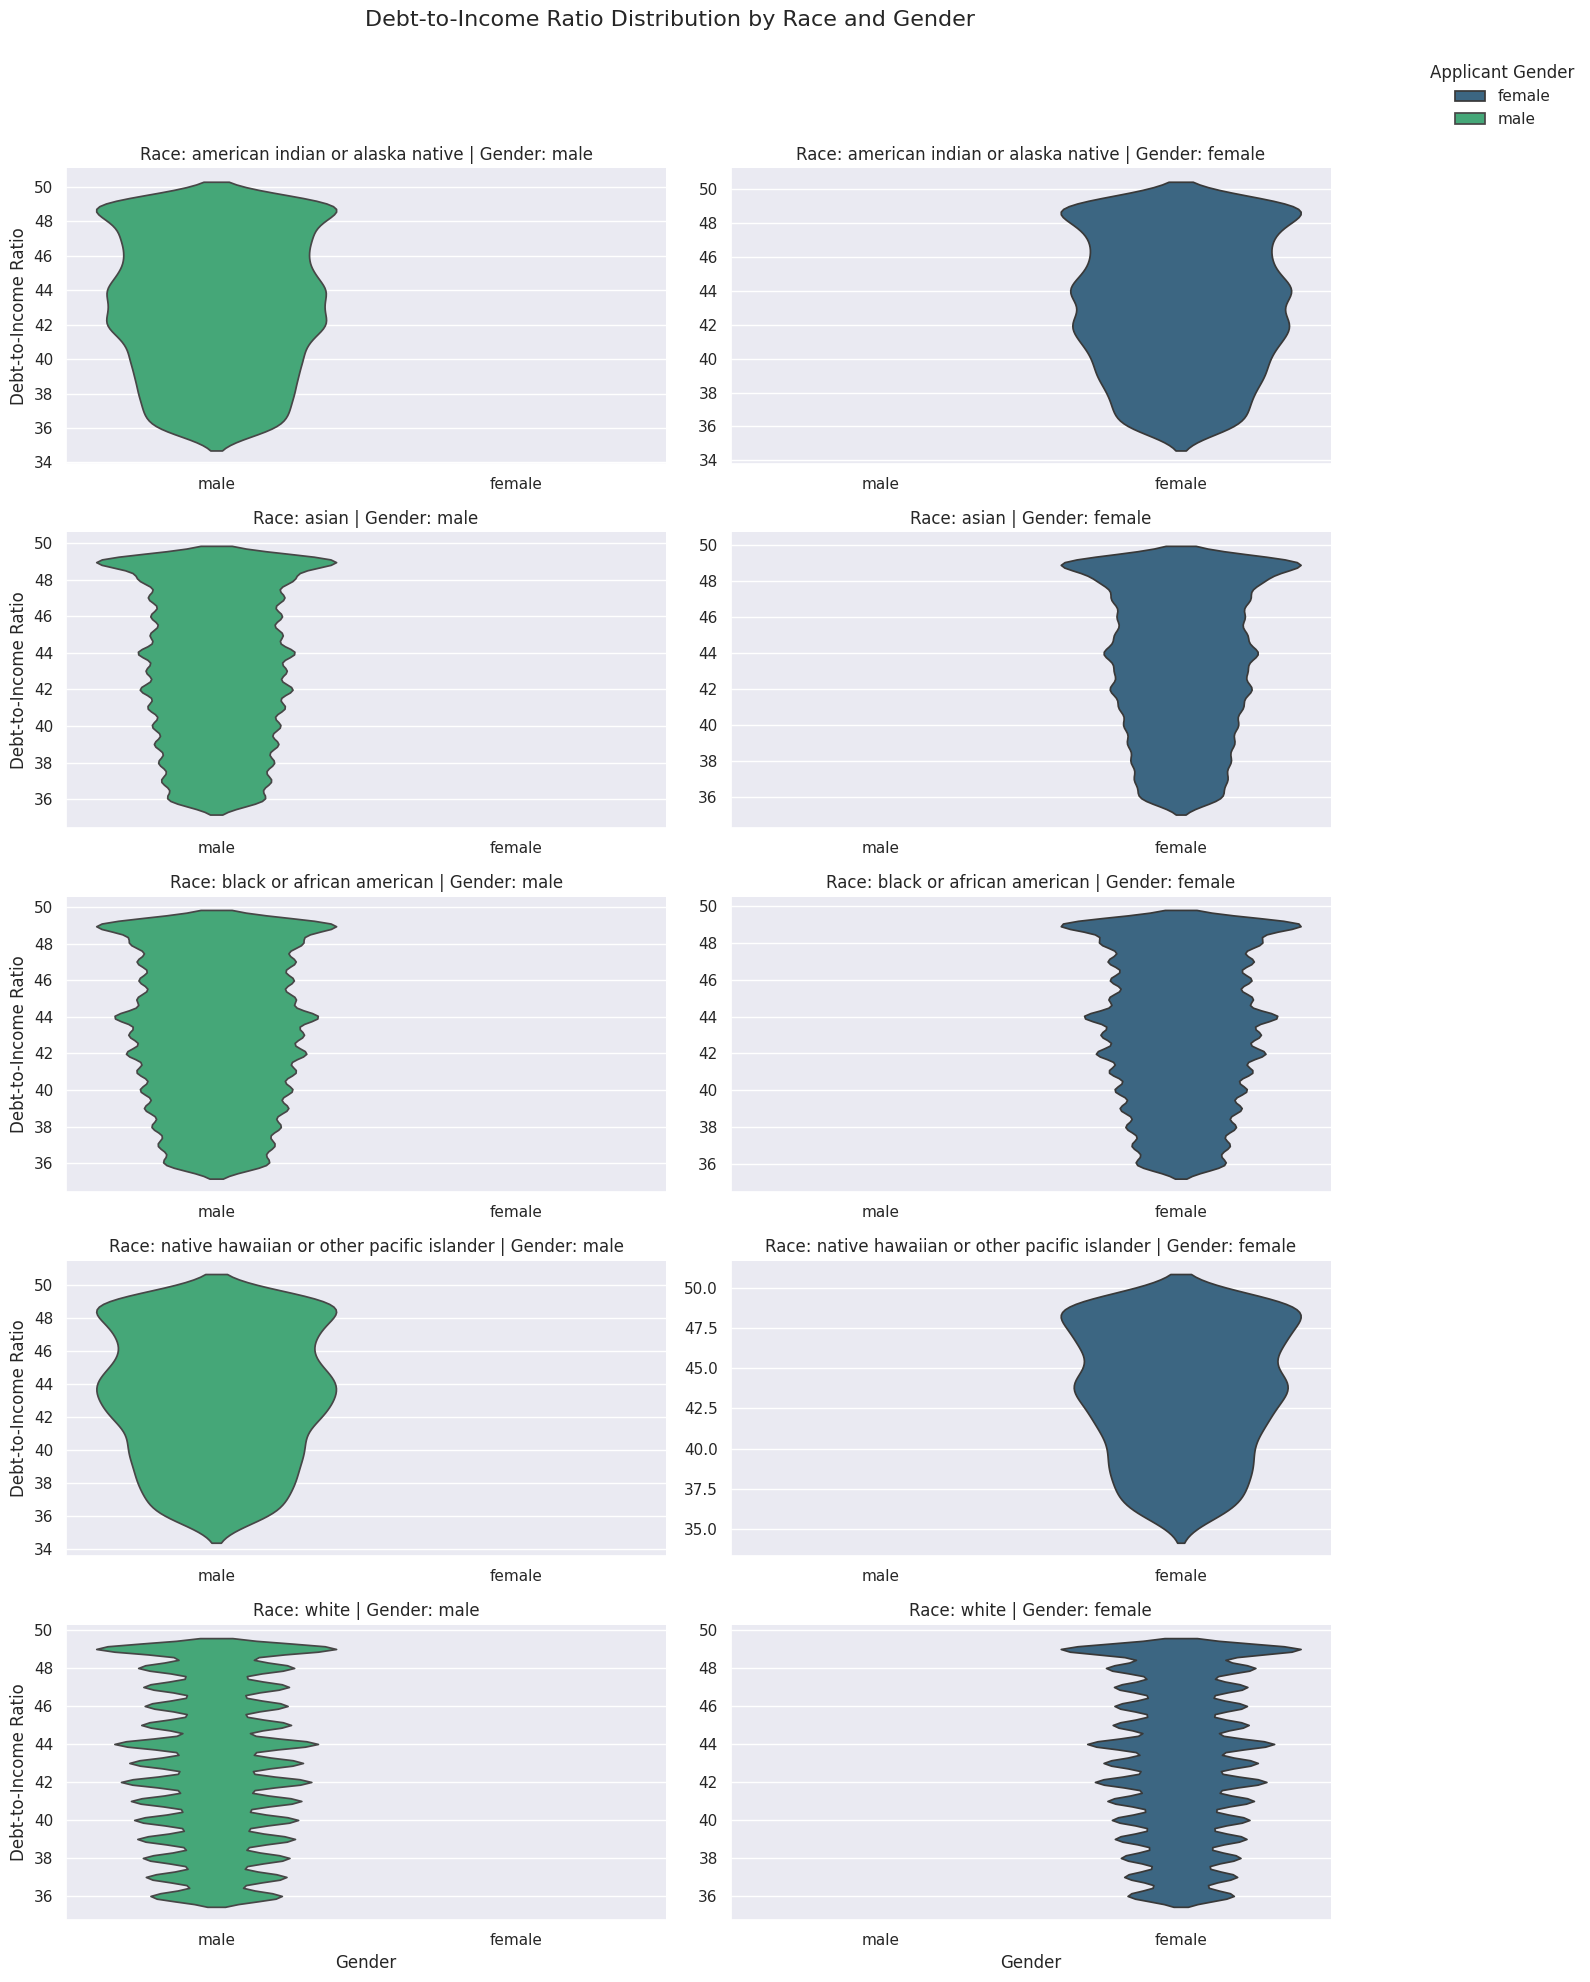

Saved: output/figures/dti_distribution_race_gender_facet_violin.png


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Set the seaborn style to 'darkgrid'.
sns.set(style="darkgrid")

# Define the order for derived_sex to suppress the warning and ensure consistent plotting
sex_order = ['male', 'female']

# 2. Create a FacetGrid object named g
# Pass hue='derived_sex' to FacetGrid for consistent coloring across columns and for the legend.
# The palette will then be applied to this hue variable.
g = sns.FacetGrid(df_filtered, row="derived_race", col="derived_sex", hue="derived_sex", height=4, aspect=1.5, palette="viridis", sharex=False, sharey=False, col_order=sex_order)

# 3. Map a seaborn.violinplot to the FacetGrid
# To resolve the ValueError, explicitly provide an 'x' variable.
# Since 'derived_sex' is already used for 'col', passing it as 'x' to violinplot will
# create one violin per facet, grouped by gender. 'inner=None' removes individual points.
# Pass the defined sex_order to the violinplot.
g.map(sns.violinplot, "derived_sex", "debt_to_income_ratio", order=sex_order, inner=None)

# 4. Set the titles for each facet
g.set_titles(row_template='Race: {row_name}', col_template='Gender: {col_name}')

# 5. Set the x-axis label to 'Gender' and the y-axis label to 'Debt-to-Income Ratio'
# Since 'x' is now explicitly 'derived_sex', label it as such.
g.set_xlabels('Gender')
g.set_ylabels('Debt-to-Income Ratio')

# 6. Add a legend
g.add_legend(title='Applicant Gender', bbox_to_anchor=(1.05, 1), loc='upper left')

# 7. Add a main title to the entire plot
plt.suptitle('Debt-to-Income Ratio Distribution by Race and Gender', y=1.02, fontsize=16)

# 8. Adjust the plot layout
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust rect to make space for suptitle and legend

# 9. Display the plot
plt.show()

# 10. Save the figure
safe_save_fig(f'{OUT_FIG_DIR}/dti_distribution_race_gender_facet_violin.png')
